In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.svm import SVR
import xgboost as xgb
from tensorflow.keras.layers import LSTM, Dense, GRU


In [3]:
def linegraph(train_dates, y_train, test_dates, y_test, predictions):
    train = pd.DataFrame({
        'Date': train_dates,
        'Close': y_train
    })
    valid = pd.DataFrame({
        'Date': test_dates,
        'Close': y_test,
        'Predictions': predictions
    })

    # Visualize the data
    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Validation')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()

# Random Forest

In [4]:
def run_random_forest(DF, n_estimators, random_state,Features, Target):
  
    features = Features
    target = Target
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        DF[features + ['Date']],
        DF[target],
        test_size=0.2,
        random_state=random_state,
        shuffle=False
    )
    
    # Saving the 'Date' column for potential use and then dropping it from training and testing datasets
    train_dates = X_train['Date']
    test_dates = X_test['Date']
    X_train.drop(['Date'], axis=1, inplace=True)
    X_test.drop(['Date'], axis=1, inplace=True)
    
    # Creating and fitting the RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    
    # Making predictions
    predictions = rf_model.predict(X_test)
    
    # Evaluating the model
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    
    # Print results
    print(f'Mean Squared Error: {mse:.3f}')
    print(f'Root Mean Squared Error: {rmse:.3f}')
    print(f'R-squared Score: {r2:.3f}')
    linegraph(train_dates, y_train, test_dates, y_test, predictions)
    # Optionally, return these metrics if you want to use them later
    return mse, rmse, r2

# SVR

In [5]:
def run_svr(Df, random_state, Features, Target):
    DF = Df
    features = Features
    target = Target
    dates = DF['Date'].values  
    
    # Initialize separate scalers for features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    # Scale features and target separately
    DF_features_scaled = feature_scaler.fit_transform(DF[features])
    DF_target_scaled = target_scaler.fit_transform(DF[[target]]) 
    
    sequence_length = 10
    X, y, X_dates = [], [], []
    for i in range(len(DF_features_scaled) - sequence_length):
        X.append(DF_features_scaled[i:(i + sequence_length), :])
        y.append(DF_target_scaled[i + sequence_length, 0])
        X_dates.append(dates[i + sequence_length])
    
    X, y, X_dates = np.array(X), np.array(y), np.array(X_dates)
    
    # Splitting dataset
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    train_dates, test_dates = X_dates[:train_size], X_dates[train_size:]
    
    svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    svr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

    y_pred = svr_model.predict(X_test.reshape(X_test.shape[0], -1))

    # Inverse transform the predictions and actuals using the correct scaler
    y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_train_inv = target_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
   
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')

# LSTM

In [6]:
def LSTM_Model(dataFrame,Features, Target, epochs, batch_size):
    DF=dataFrame
    features = Features
    target=Target
    dates = DF['Date'].values
    print(features)
    print(target)
    print(epochs)
    print(batch_size)
    # Data scaling
    scaler = MinMaxScaler()
    DF_scaled = scaler.fit_transform(DF[features + [target]])
    
    # Preparing input sequences
    sequence_length = 10
    X, y, X_dates = [], [], []
    for i in range(len(DF_scaled) - sequence_length):
        X.append(DF_scaled[i:(i + sequence_length), :-1])
        y.append(DF_scaled[i + sequence_length, -1])
        X_dates.append(dates[i + sequence_length])
    X, y, X_dates = np.array(X), np.array(y), np.array(X_dates)
    y = y.reshape(-1, 1)
    
    # Splitting dataset
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    train_dates, test_dates = X_dates[:train_size], X_dates[train_size:]
    
    # Model building
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Model training
    model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2)
    
    # Model prediction
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :].reshape(X_test.shape[0], -1)
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    y_test_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_test.reshape(-1, 1)), axis=1))[:, -1]
    train_inv_y = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]
    
    # Evaluation
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
    
    # Print results
    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')
    
    return train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv

# Gated Recurrent Units GRU

In [7]:
def GRU_Model(dataFrame,Features, Target, epochs, batch_size):
    TestDF = dataFrame
    target = Target
    features = Features
    print(features)
    print(target)
    print(epochs)
    print(batch_size)
    scaler = MinMaxScaler()
    TestDF[features] = scaler.fit_transform(TestDF[features])
    TestDF[target] = scaler.fit_transform(TestDF[[target]])
    def create_sequences(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X.iloc[i:(i + time_steps)].values)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 10

    X, y = create_sequences(TestDF[features], TestDF[target], time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, shuffle=False)

    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        GRU(50),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_rescaled, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_rescaled, predictions)

    print(f'Mean Squared Error (MSE): {mse:.3f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
    print(f'R-squared Score (R2): {r2:.3f}')

# XGBoost

In [8]:
def run_xgboost(Data, Features, Target, random_state):
    
    DF = Data
    features = Features
    target = Target
    # Splitting data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        DF[features + ['Date']],
        DF[target],
        test_size=0.2,
        random_state=random_state,
        shuffle=False
    )
    
    train_dates = X_train['Date']
    test_dates = X_test['Date']
    X_train.drop(['Date'], axis=1, inplace=True)
    X_test.drop(['Date'], axis=1, inplace=True)
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("R-squared:", r2)
    linegraph(train_dates, y_train, test_dates, y_test, y_pred)

In [9]:
Data = pd.read_csv("Data2/BATASHOE_data.csv")

In [10]:
Data.head()

,Date,Open,High,Low,Close,Volume
0,10/1/2012,483.0,490.0,483.0,488.4,800
1,10/2/2012,492.0,492.0,487.0,490.2,1600
2,10/3/2012,487.6,487.6,487.6,487.6,100
3,10/4/2012,484.2,484.2,484.2,484.2,300
4,10/7/2012,485.3,485.3,485.2,485.2,900


In [11]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646 entries, 0 to 2645
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2646 non-null   object 
 1   Open    2646 non-null   float64
 2   High    2646 non-null   float64
 3   Low     2646 non-null   float64
 4   Close   2646 non-null   float64
 5   Volume  2646 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 124.2+ KB


In [12]:
Data['Date'] = pd.to_datetime(Data['Date'])

In [13]:
Data.head()

,Date,Open,High,Low,Close,Volume
0,2012-10-01,483.0,490.0,483.0,488.4,800
1,2012-10-02,492.0,492.0,487.0,490.2,1600
2,2012-10-03,487.6,487.6,487.6,487.6,100
3,2012-10-04,484.2,484.2,484.2,484.2,300
4,2012-10-07,485.3,485.3,485.2,485.2,900


In [14]:
Data = Data[Data['Date'] >= '2021-01-01']

In [15]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746 entries, 1900 to 2645
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    746 non-null    datetime64[ns]
 1   Open    746 non-null    float64       
 2   High    746 non-null    float64       
 3   Low     746 non-null    float64       
 4   Close   746 non-null    float64       
 5   Volume  746 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 40.8 KB


In [16]:
Data.describe()

,Date,Open,High,Low,Close,Volume
count,746,746.000000,746.000000,746.000000,746.000000,746.000000
mean,2022-08-03 04:28:18.659517440,897.373727,904.963003,890.964745,897.583512,3467.829759
min,2021-01-03 00:00:00,639.600000,648.800000,639.600000,642.400000,1.000000
25%,2021-10-28 18:00:00,885.000000,898.000000,876.475000,883.575000,465.250000
50%,2022-08-03 12:00:00,937.100000,949.500000,928.000000,936.200000,1494.000000
75%,2023-05-16 18:00:00,977.000000,984.000000,971.750000,977.725000,3680.750000
max,2024-02-20 00:00:00,1037.000000,1056.000000,1019.700000,1033.400000,70936.000000
std,NaN,112.404894,113.935382,110.776837,112.532747,6186.691533


In [17]:
def fill_missing_with_mean(df):
    result = df.copy()
    for i in range(len(df)):
        if pd.isnull(df.iloc[i]):
            prev_index = i - 1
            next_index = i + 1
            while pd.isnull(df.iloc[prev_index]):
                prev_index -= 1
            while pd.isnull(df.iloc[next_index]):
                next_index += 1
            prev_val = df.iloc[prev_index] if prev_index >= 0 else np.nan
            next_val = df.iloc[next_index] if next_index < len(df) else np.nan
            if pd.notnull(prev_val) and pd.notnull(next_val):
                result.iloc[i] = (prev_val + next_val) / 2
    return result

# Feature Engineering

In [18]:
Data.set_index('Date', inplace=True)

In [19]:
all_dates = pd.date_range(start=Data.index.min(), end=Data.index.max(), freq='D')

In [20]:
Data = Data.reindex(all_dates)

In [21]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,700.0,715.0,700.0,707.9,7739.0
2021-01-04,707.9,708.0,701.6,703.4,2284.0
2021-01-05,701.1,702.6,693.2,694.8,8977.0
2021-01-06,695.0,711.8,693.2,704.2,2668.0
2021-01-07,696.3,704.0,695.0,696.3,2362.0
2021-01-08,NaN,NaN,NaN,NaN,NaN
2021-01-09,NaN,NaN,NaN,NaN,NaN
2021-01-10,700.0,702.0,695.0,700.1,3419.0
2021-01-11,695.1,708.8,695.0,699.8,3206.0
2021-01-12,700.0,701.0,695.8,697.0,2656.0


In [22]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1144 entries, 2021-01-03 to 2024-02-20
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    746 non-null    float64
 1   High    746 non-null    float64
 2   Low     746 non-null    float64
 3   Close   746 non-null    float64
 4   Volume  746 non-null    float64
dtypes: float64(5)
memory usage: 53.6 KB


In [23]:
Df = fill_missing_with_mean(Data['Open'])
Data['Open'] = Df

In [24]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,700.00,715.0,700.0,707.9,7739.0
2021-01-04,707.90,708.0,701.6,703.4,2284.0
2021-01-05,701.10,702.6,693.2,694.8,8977.0
2021-01-06,695.00,711.8,693.2,704.2,2668.0
2021-01-07,696.30,704.0,695.0,696.3,2362.0
2021-01-08,698.15,NaN,NaN,NaN,NaN
2021-01-09,698.15,NaN,NaN,NaN,NaN
2021-01-10,700.00,702.0,695.0,700.1,3419.0
2021-01-11,695.10,708.8,695.0,699.8,3206.0
2021-01-12,700.00,701.0,695.8,697.0,2656.0


In [25]:
Df = fill_missing_with_mean(Data['High'])
Data['High'] = Df

In [26]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,700.00,715.0,700.0,707.9,7739.0
2021-01-04,707.90,708.0,701.6,703.4,2284.0
2021-01-05,701.10,702.6,693.2,694.8,8977.0
2021-01-06,695.00,711.8,693.2,704.2,2668.0
2021-01-07,696.30,704.0,695.0,696.3,2362.0
2021-01-08,698.15,703.0,NaN,NaN,NaN
2021-01-09,698.15,703.0,NaN,NaN,NaN
2021-01-10,700.00,702.0,695.0,700.1,3419.0
2021-01-11,695.10,708.8,695.0,699.8,3206.0
2021-01-12,700.00,701.0,695.8,697.0,2656.0


In [27]:
Df = fill_missing_with_mean(Data['Low'])
Data['Low'] = Df

In [28]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,700.00,715.0,700.00,707.9,7739.0
2021-01-04,707.90,708.0,701.60,703.4,2284.0
2021-01-05,701.10,702.6,693.20,694.8,8977.0
2021-01-06,695.00,711.8,693.20,704.2,2668.0
2021-01-07,696.30,704.0,695.00,696.3,2362.0
2021-01-08,698.15,703.0,695.00,NaN,NaN
2021-01-09,698.15,703.0,695.00,NaN,NaN
2021-01-10,700.00,702.0,695.00,700.1,3419.0
2021-01-11,695.10,708.8,695.00,699.8,3206.0
2021-01-12,700.00,701.0,695.80,697.0,2656.0


In [29]:
Df = fill_missing_with_mean(Data['Close'])
Data['Close'] = Df

In [30]:
Data.head(15)

,Open,High,Low,Close,Volume
2021-01-03,700.00,715.0,700.00,707.9,7739.0
2021-01-04,707.90,708.0,701.60,703.4,2284.0
2021-01-05,701.10,702.6,693.20,694.8,8977.0
2021-01-06,695.00,711.8,693.20,704.2,2668.0
2021-01-07,696.30,704.0,695.00,696.3,2362.0
2021-01-08,698.15,703.0,695.00,698.2,NaN
2021-01-09,698.15,703.0,695.00,698.2,NaN
2021-01-10,700.00,702.0,695.00,700.1,3419.0
2021-01-11,695.10,708.8,695.00,699.8,3206.0
2021-01-12,700.00,701.0,695.80,697.0,2656.0


In [31]:
Data['Volume'] = Data['Volume'].fillna(0)

In [32]:
Data.head(50)

,Open,High,Low,Close,Volume
2021-01-03,700.00,715.00,700.00,707.90,7739.0
2021-01-04,707.90,708.00,701.60,703.40,2284.0
2021-01-05,701.10,702.60,693.20,694.80,8977.0
2021-01-06,695.00,711.80,693.20,704.20,2668.0
2021-01-07,696.30,704.00,695.00,696.30,2362.0
2021-01-08,698.15,703.00,695.00,698.20,0.0
2021-01-09,698.15,703.00,695.00,698.20,0.0
2021-01-10,700.00,702.00,695.00,700.10,3419.0
2021-01-11,695.10,708.80,695.00,699.80,3206.0
2021-01-12,700.00,701.00,695.80,697.00,2656.0


In [33]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1144 entries, 2021-01-03 to 2024-02-20
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1144 non-null   float64
 1   High    1144 non-null   float64
 2   Low     1144 non-null   float64
 3   Close   1144 non-null   float64
 4   Volume  1144 non-null   float64
dtypes: float64(5)
memory usage: 53.6 KB


In [34]:
Data.reset_index(inplace=True)
Data.rename(columns={'index': 'Date'}, inplace=True)

In [35]:
Data['day'] = Data['Date'].dt.day
Data['month'] = Data['Date'].dt.month
Data['year'] = Data['Date'].dt.year


Create column for 1 day, 1 week, 15 days, 1 month prediction of closing price

In [36]:
Data['1_day'] = Data['Close'].shift(-1)
Data['1_week'] = Data['Close'].shift(-7)
Data['15_days'] = Data['Close'].shift(-15)
Data['1_month'] = Data['Close'].shift(-30)

In [37]:
Data.head(30)

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
0,2021-01-03,700.00,715.00,700.00,707.90,7739.0,3,1,2021,703.40,700.10,695.00,695.00
1,2021-01-04,707.90,708.00,701.60,703.40,2284.0,4,1,2021,694.80,699.80,695.40,693.40
2,2021-01-05,701.10,702.60,693.20,694.80,8977.0,5,1,2021,704.20,697.00,694.60,693.20
3,2021-01-06,695.00,711.80,693.20,704.20,2668.0,6,1,2021,696.30,698.80,696.50,693.85
4,2021-01-07,696.30,704.00,695.00,696.30,2362.0,7,1,2021,698.20,703.00,696.05,693.85
5,2021-01-08,698.15,703.00,695.00,698.20,0.0,8,1,2021,698.20,701.10,696.05,694.50
6,2021-01-09,698.15,703.00,695.00,698.20,0.0,9,1,2021,700.10,701.10,695.60,693.20
7,2021-01-10,700.00,702.00,695.00,700.10,3419.0,10,1,2021,699.80,699.20,697.90,693.30
8,2021-01-11,695.10,708.80,695.00,699.80,3206.0,11,1,2021,697.00,695.00,694.20,693.20
9,2021-01-12,700.00,701.00,695.80,697.00,2656.0,12,1,2021,698.80,695.40,695.00,693.20


In [38]:
Data.describe()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
count,1144,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1143.000000,1137.000000,1129.000000,1114.000000
mean,2022-07-28 12:00:00,893.550699,901.104327,887.108741,893.902928,2261.364510,15.661713,6.306818,2022.090909,894.065661,895.094063,896.476395,899.145646
min,2021-01-03 00:00:00,639.600000,648.800000,639.600000,642.400000,0.000000,1.000000,1.000000,2021.000000,642.400000,642.400000,642.400000,642.400000
25%,2021-10-15 18:00:00,882.375000,891.487500,872.725000,880.700000,0.000000,8.000000,3.000000,2021.000000,880.750000,881.200000,883.200000,886.225000
50%,2022-07-28 12:00:00,936.900000,948.750000,926.900000,938.750000,426.000000,16.000000,6.000000,2022.000000,938.750000,938.750000,939.400000,940.250000
75%,2023-05-10 06:00:00,975.700000,982.625000,970.000000,976.550000,2218.000000,23.000000,9.000000,2023.000000,976.600000,977.000000,977.300000,977.500000
max,2024-02-20 00:00:00,1037.000000,1056.000000,1019.700000,1033.400000,70936.000000,31.000000,12.000000,2024.000000,1033.400000,1033.400000,1033.400000,1033.400000
std,NaN,115.569613,117.209059,113.673619,115.634672,5261.001898,8.774819,3.531796,0.898402,115.554162,114.985101,114.208162,112.615934


# Missing Value

In [39]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1144 non-null   datetime64[ns]
 1   Open     1144 non-null   float64       
 2   High     1144 non-null   float64       
 3   Low      1144 non-null   float64       
 4   Close    1144 non-null   float64       
 5   Volume   1144 non-null   float64       
 6   day      1144 non-null   int32         
 7   month    1144 non-null   int32         
 8   year     1144 non-null   int32         
 9   1_day    1143 non-null   float64       
 10  1_week   1137 non-null   float64       
 11  15_days  1129 non-null   float64       
 12  1_month  1114 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3)
memory usage: 102.9 KB


In [40]:
missing_values = Data.isnull().sum()
print(missing_values)

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
day         0
month       0
year        0
1_day       1
1_week      7
15_days    15
1_month    30
dtype: int64


In [41]:
Data=Data.dropna()

In [42]:
missing_values = Data.isnull().sum()
print(missing_values)

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
day        0
month      0
year       0
1_day      0
1_week     0
15_days    0
1_month    0
dtype: int64


# Check Outliers

In [43]:
Data[['Open','High','Low','Close']].describe()

,Open,High,Low,Close
count,1114.000000,1114.000000,1114.000000,1114.000000
mean,890.741113,898.283348,884.341113,891.048519
std,115.814142,117.486650,113.913159,115.843513
min,639.600000,648.800000,639.600000,642.400000
25%,880.650000,888.000000,871.025000,877.475000
50%,930.500000,945.000000,926.400000,932.700000
75%,973.750000,979.950000,967.300000,975.000000
max,1037.000000,1056.000000,1019.700000,1033.400000


<Axes: >

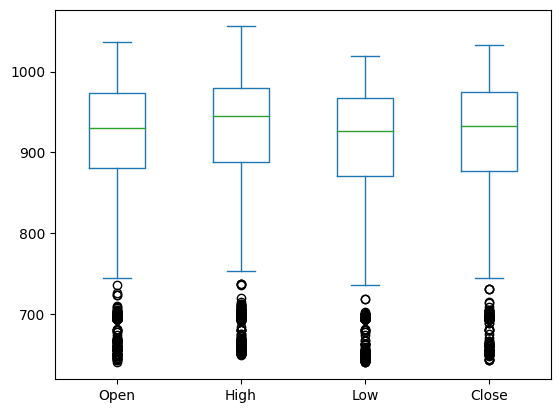

In [44]:
Data[['Open','High','Low','Close']].plot(kind='box')

<Axes: >

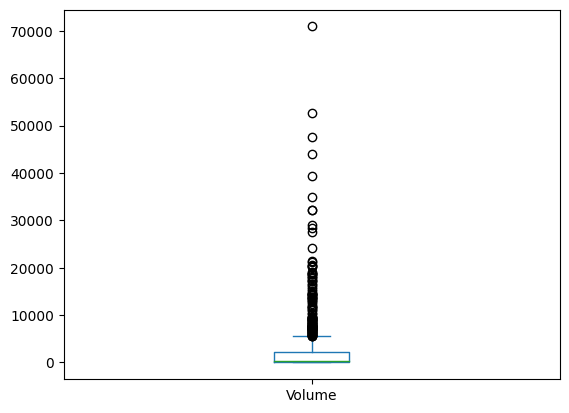

In [45]:
Data[['Volume']].plot(kind='box')

In [46]:
Data.describe()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month
count,1114,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000,1114.000000
mean,2022-07-13 12:00:00,890.741113,898.283348,884.341113,891.048519,2294.870736,15.657092,6.431777,2022.039497,891.310009,892.961804,895.079219,899.145646
min,2021-01-03 00:00:00,639.600000,648.800000,639.600000,642.400000,0.000000,1.000000,1.000000,2021.000000,642.400000,642.400000,642.400000,642.400000
25%,2021-10-08 06:00:00,880.650000,888.000000,871.025000,877.475000,0.000000,8.000000,3.000000,2021.000000,877.725000,880.700000,882.025000,886.225000
50%,2022-07-13 12:00:00,930.500000,945.000000,926.400000,932.700000,410.000000,16.000000,6.000000,2022.000000,932.850000,935.250000,938.750000,940.250000
75%,2023-04-17 18:00:00,973.750000,979.950000,967.300000,975.000000,2227.750000,23.000000,9.000000,2023.000000,975.075000,975.300000,975.875000,977.500000
max,2024-01-21 00:00:00,1037.000000,1056.000000,1019.700000,1033.400000,70936.000000,31.000000,12.000000,2024.000000,1033.400000,1033.400000,1033.400000,1033.400000
std,NaN,115.814142,117.486650,113.913159,115.843513,5324.118479,8.767385,3.493971,0.853228,115.758466,115.191324,114.331620,112.615934


In [47]:
close_prices = Data['Close']
Q1 = close_prices.quantile(0.25)
Q3 = close_prices.quantile(0.75)
print(Q1)
print(Q3)

877.4750000000001
975.0


In [48]:
IQR = Q3 - Q1
print(IQR)

97.52499999999986


In [49]:
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
print(lower_bound)
print(upper_bound)

584.9000000000005
1267.5749999999996


In [50]:
outliers = Data[(close_prices < lower_bound) | (close_prices > upper_bound)]
print(outliers)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, day, month, year, 1_day, 1_week, 15_days, 1_month]
Index: []


No outliers

In [51]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1114 entries, 0 to 1113
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     1114 non-null   datetime64[ns]
 1   Open     1114 non-null   float64       
 2   High     1114 non-null   float64       
 3   Low      1114 non-null   float64       
 4   Close    1114 non-null   float64       
 5   Volume   1114 non-null   float64       
 6   day      1114 non-null   int32         
 7   month    1114 non-null   int32         
 8   year     1114 non-null   int32         
 9   1_day    1114 non-null   float64       
 10  1_week   1114 non-null   float64       
 11  15_days  1114 non-null   float64       
 12  1_month  1114 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int32(3)
memory usage: 108.8 KB


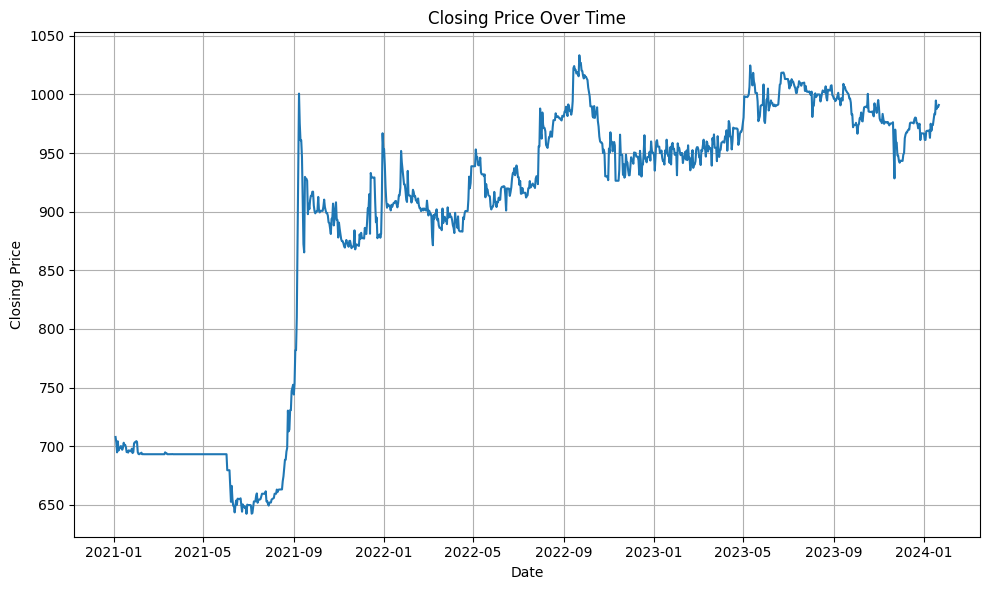

In [52]:
plt.figure(figsize=(10,6))
plt.plot(Data['Date'], Data['Close']) 
plt.title('Closing Price Over Time')  
plt.xlabel('Date')  
plt.ylabel('Closing Price')  
plt.grid(True)  
plt.tight_layout() 
plt.show()

# Add SMA, RSI, MACD

In [53]:
Data.loc[:, 'SMA_7'] = Data['Close'].rolling(window=7).mean()
Data.loc[:, 'SMA_7'].fillna(Data['Close'].iloc[0], inplace=True)

In [54]:
Data['MACD'] = Data['Close'].ewm(span=26, adjust=False).mean() - Data['Close'].ewm(span=12, adjust=False).mean()
Data['Signal_Line'] = Data['MACD'].ewm(span=9, adjust=False).mean()
Data['ema'] = Data['Close'].ewm(span=5, adjust=False).mean()

In [55]:
Data.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,700.0,715.0,700.0,707.9,7739.0,3,1,2021,703.4,700.1,695.00,695.00,707.9,0.000000,0.000000,707.900000
1,2021-01-04,707.9,708.0,701.6,703.4,2284.0,4,1,2021,694.8,699.8,695.40,693.40,707.9,0.358974,0.071795,706.400000
2,2021-01-05,701.1,702.6,693.2,694.8,8977.0,5,1,2021,704.2,697.0,694.60,693.20,707.9,1.322171,0.321870,702.533333
3,2021-01-06,695.0,711.8,693.2,704.2,2668.0,6,1,2021,696.3,698.8,696.50,693.85,707.9,1.311887,0.519874,703.088889
4,2021-01-07,696.3,704.0,695.0,696.3,2362.0,7,1,2021,698.2,703.0,696.05,693.85,707.9,1.919079,0.799715,700.825926


In [56]:
Dataset = Data.copy()

# Apply Random Forest

1 day ahead prediction

Mean Squared Error: 56.494
Root Mean Squared Error: 7.516
R-squared Score: 0.824


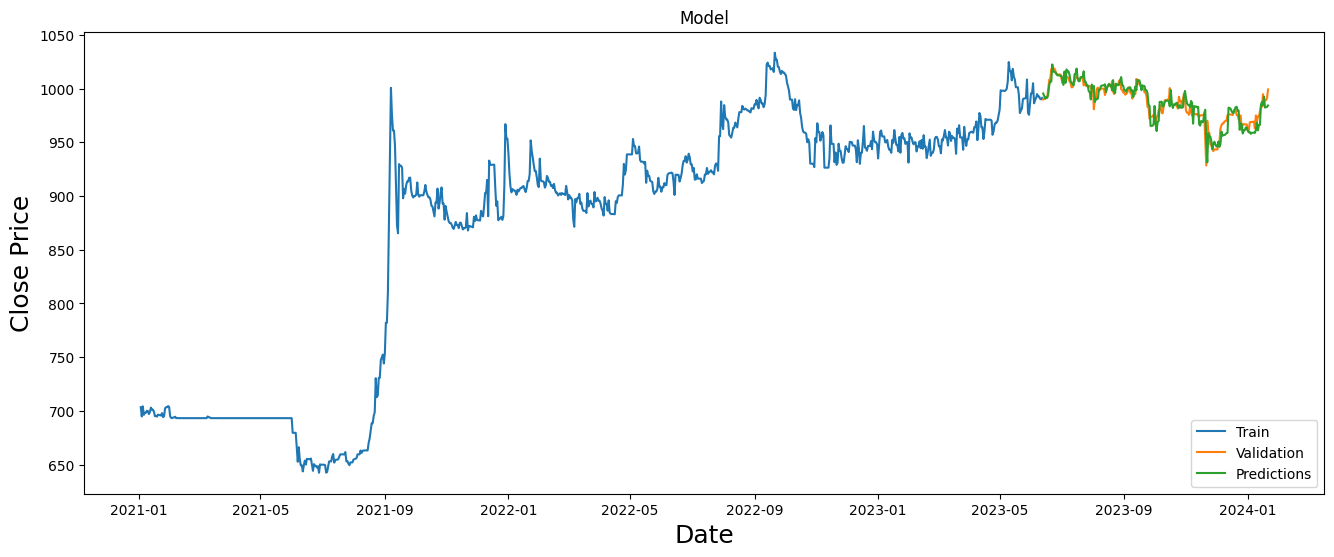

(56.49358977229569, 7.5162217750872475, 0.8242442314998106)

In [57]:
RfDF1 = Dataset.copy()
n_estimators = 150
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)

1 week ahead prediction 

Mean Squared Error: 164.236
Root Mean Squared Error: 12.815
R-squared Score: 0.502


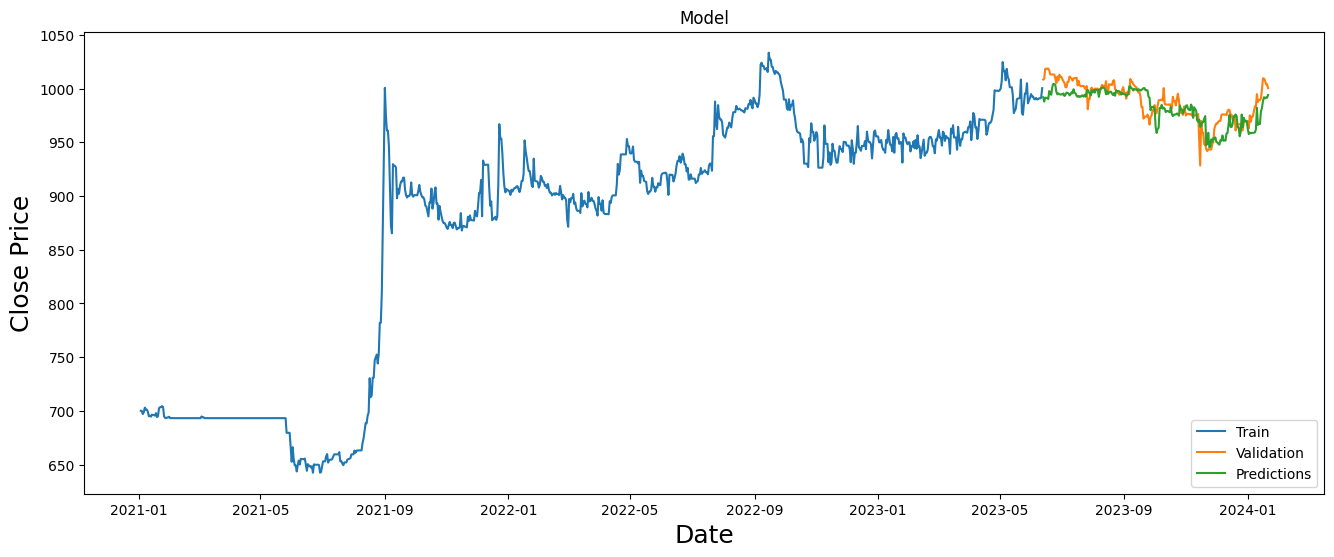

(164.23566037618326, 12.815446163758141, 0.5020327784408974)

In [58]:
RfDF7 = Dataset.copy()
n_estimators = 150
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

15 days ahead prediction 

Mean Squared Error: 514.085
Root Mean Squared Error: 22.673
R-squared Score: -0.691


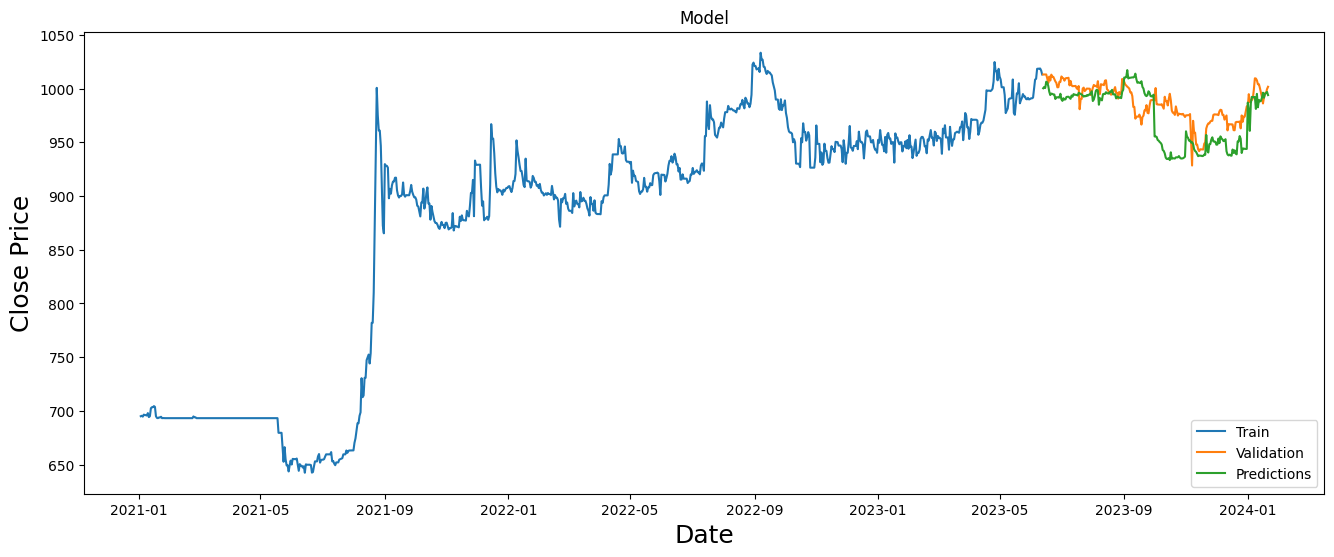

(514.0847802264424, 22.67343776815599, -0.6905870861538022)

In [59]:
RfDF15 = Dataset.copy()
n_estimators = 300
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

Mean Squared Error: 581.429
Root Mean Squared Error: 24.113
R-squared Score: -1.054


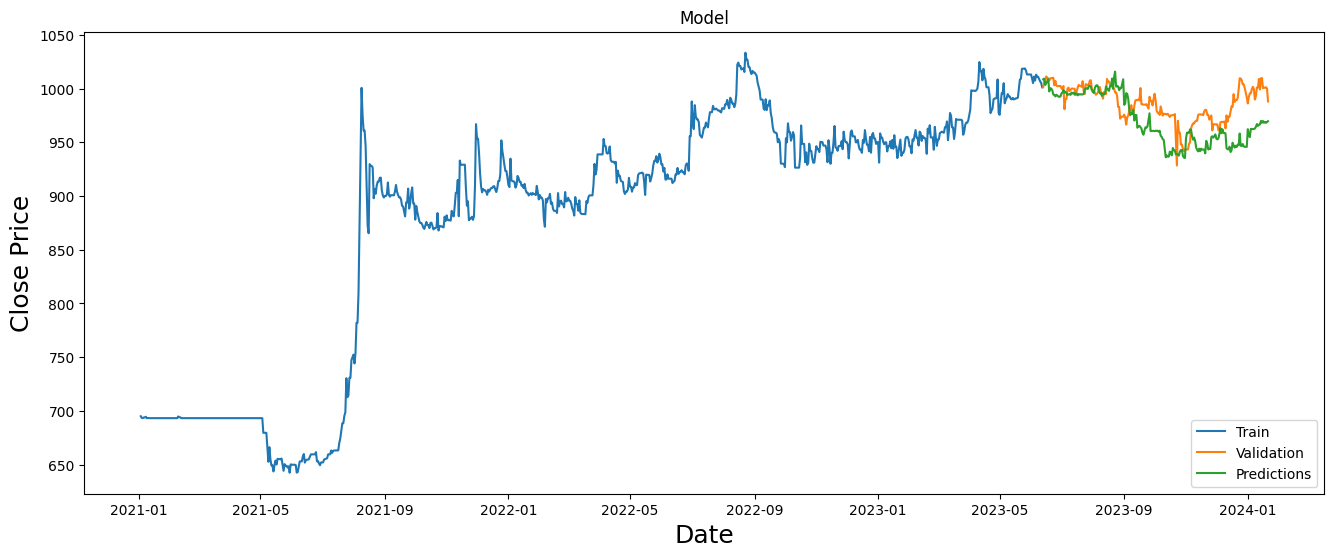

(581.4294145397542, 24.112847499616347, -1.0544603669474402)

In [63]:
RfDF30 = Dataset.copy()
n_estimators = 300
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_month'
run_random_forest(RfDF30, n_estimators, random_state,features, target)

# Apply LSTM

1 Day

In [64]:
LDF1 = Dataset.copy()
LDF1.head()


,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,700.0,715.0,700.0,707.9,7739.0,3,1,2021,703.4,700.1,695.00,695.00,707.9,0.000000,0.000000,707.900000
1,2021-01-04,707.9,708.0,701.6,703.4,2284.0,4,1,2021,694.8,699.8,695.40,693.40,707.9,0.358974,0.071795,706.400000
2,2021-01-05,701.1,702.6,693.2,694.8,8977.0,5,1,2021,704.2,697.0,694.60,693.20,707.9,1.322171,0.321870,702.533333
3,2021-01-06,695.0,711.8,693.2,704.2,2668.0,6,1,2021,696.3,698.8,696.50,693.85,707.9,1.311887,0.519874,703.088889
4,2021-01-07,696.3,704.0,695.0,696.3,2362.0,7,1,2021,698.2,703.0,696.05,693.85,707.9,1.919079,0.799715,700.825926


In [79]:
epochs = 90
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_day
90
40
Epoch 1/90
23/23 - 3s - loss: 0.1133 - 3s/epoch - 116ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0078 - 169ms/epoch - 7ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0032 - 169ms/epoch - 7ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0023 - 185ms/epoch - 8ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0021 - 185ms/epoch - 8ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0020 - 216ms/epoch - 9ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0019 - 185ms/epoch - 8ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0019 - 178ms/epoch - 8ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0018 - 185ms/epoch - 8ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0017 - 185ms/epoch - 8ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0016 - 201ms/epoch - 9ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0016 - 185ms/epoch - 8ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0016 - 201ms/epoch - 9ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0015 - 216ms/epo

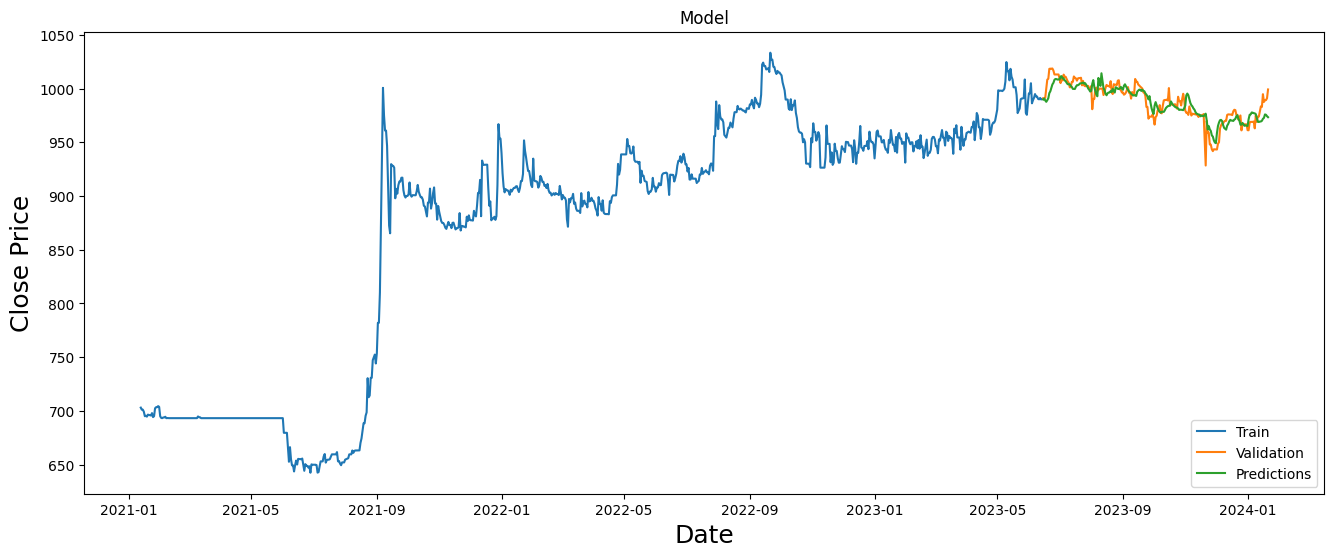

In [80]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

1 week

In [81]:
LDF7 = Dataset.copy()
LDF7.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,700.0,715.0,700.0,707.9,7739.0,3,1,2021,703.4,700.1,695.00,695.00,707.9,0.000000,0.000000,707.900000
1,2021-01-04,707.9,708.0,701.6,703.4,2284.0,4,1,2021,694.8,699.8,695.40,693.40,707.9,0.358974,0.071795,706.400000
2,2021-01-05,701.1,702.6,693.2,694.8,8977.0,5,1,2021,704.2,697.0,694.60,693.20,707.9,1.322171,0.321870,702.533333
3,2021-01-06,695.0,711.8,693.2,704.2,2668.0,6,1,2021,696.3,698.8,696.50,693.85,707.9,1.311887,0.519874,703.088889
4,2021-01-07,696.3,704.0,695.0,696.3,2362.0,7,1,2021,698.2,703.0,696.05,693.85,707.9,1.919079,0.799715,700.825926


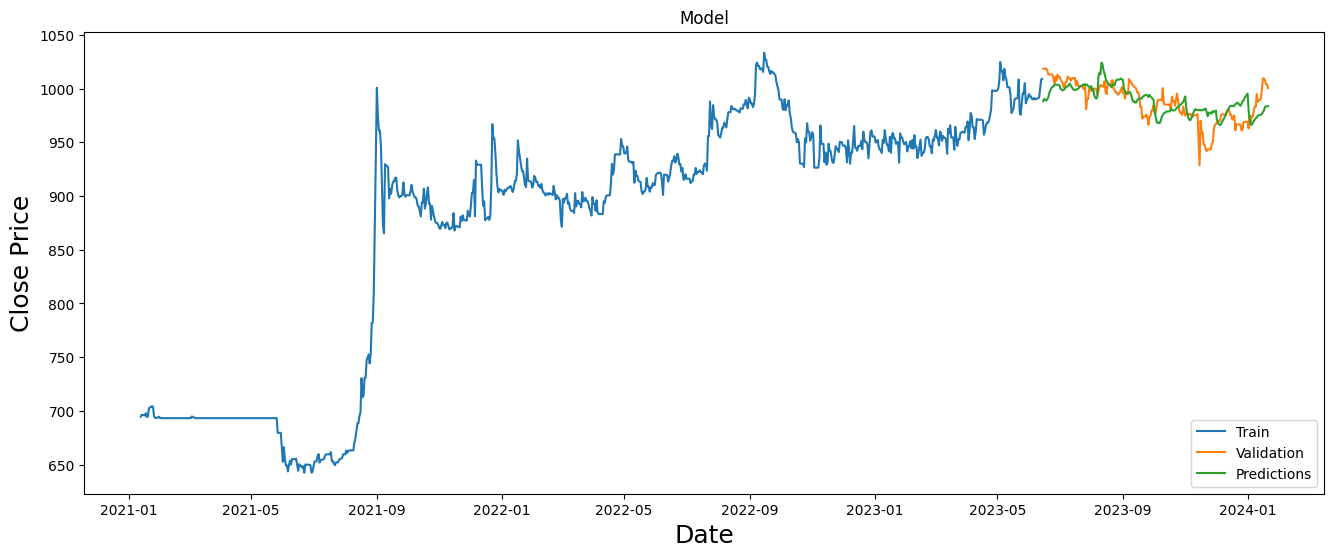

In [86]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [85]:
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_week
120
40
Epoch 1/120
23/23 - 3s - loss: 0.0593 - 3s/epoch - 113ms/step
Epoch 2/120
23/23 - 0s - loss: 0.0095 - 185ms/epoch - 8ms/step
Epoch 3/120
23/23 - 0s - loss: 0.0054 - 185ms/epoch - 8ms/step
Epoch 4/120
23/23 - 0s - loss: 0.0049 - 169ms/epoch - 7ms/step
Epoch 5/120
23/23 - 0s - loss: 0.0045 - 185ms/epoch - 8ms/step
Epoch 6/120
23/23 - 0s - loss: 0.0042 - 194ms/epoch - 8ms/step
Epoch 7/120
23/23 - 0s - loss: 0.0040 - 169ms/epoch - 7ms/step
Epoch 8/120
23/23 - 0s - loss: 0.0038 - 185ms/epoch - 8ms/step
Epoch 9/120
23/23 - 0s - loss: 0.0037 - 185ms/epoch - 8ms/step
Epoch 10/120
23/23 - 0s - loss: 0.0034 - 185ms/epoch - 8ms/step
Epoch 11/120
23/23 - 0s - loss: 0.0032 - 178ms/epoch - 8ms/step
Epoch 12/120
23/23 - 0s - loss: 0.0032 - 169ms/epoch - 7ms/step
Epoch 13/120
23/23 - 0s - loss: 0.0031 - 185ms/epoch - 8ms/step
Epoch 14/120
23/23 - 0s - loss: 0.0028 - 185ms/epoch - 8ms/step
Epoch 15/120
23/23 - 0s - loss: 0

15 days

In [95]:
LDF15 = Dataset.copy()
epochs = 180
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
15_days
180
40
Epoch 1/180
23/23 - 3s - loss: 0.1350 - 3s/epoch - 115ms/step
Epoch 2/180
23/23 - 0s - loss: 0.0127 - 190ms/epoch - 8ms/step
Epoch 3/180
23/23 - 0s - loss: 0.0084 - 170ms/epoch - 7ms/step
Epoch 4/180
23/23 - 0s - loss: 0.0078 - 180ms/epoch - 8ms/step
Epoch 5/180
23/23 - 0s - loss: 0.0074 - 180ms/epoch - 8ms/step
Epoch 6/180
23/23 - 0s - loss: 0.0069 - 190ms/epoch - 8ms/step
Epoch 7/180
23/23 - 0s - loss: 0.0063 - 190ms/epoch - 8ms/step
Epoch 8/180
23/23 - 0s - loss: 0.0059 - 200ms/epoch - 9ms/step
Epoch 9/180
23/23 - 0s - loss: 0.0056 - 190ms/epoch - 8ms/step
Epoch 10/180
23/23 - 0s - loss: 0.0049 - 190ms/epoch - 8ms/step
Epoch 11/180
23/23 - 0s - loss: 0.0046 - 180ms/epoch - 8ms/step
Epoch 12/180
23/23 - 0s - loss: 0.0040 - 180ms/epoch - 8ms/step
Epoch 13/180
23/23 - 0s - loss: 0.0036 - 180ms/epoch - 8ms/step
Epoch 14/180
23/23 - 0s - loss: 0.0030 - 180ms/epoch - 8ms/step
Epoch 15/180
23/23 - 0s - loss: 

Epoch 128/180
23/23 - 0s - loss: 0.0012 - 169ms/epoch - 7ms/step
Epoch 129/180
23/23 - 0s - loss: 0.0014 - 178ms/epoch - 8ms/step
Epoch 130/180
23/23 - 0s - loss: 0.0013 - 169ms/epoch - 7ms/step
Epoch 131/180
23/23 - 0s - loss: 0.0019 - 169ms/epoch - 7ms/step
Epoch 132/180
23/23 - 0s - loss: 0.0012 - 169ms/epoch - 7ms/step
Epoch 133/180
23/23 - 0s - loss: 0.0012 - 163ms/epoch - 7ms/step
Epoch 134/180
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 135/180
23/23 - 0s - loss: 0.0011 - 169ms/epoch - 7ms/step
Epoch 136/180
23/23 - 0s - loss: 0.0012 - 178ms/epoch - 8ms/step
Epoch 137/180
23/23 - 0s - loss: 0.0012 - 169ms/epoch - 7ms/step
Epoch 138/180
23/23 - 0s - loss: 0.0012 - 169ms/epoch - 7ms/step
Epoch 139/180
23/23 - 0s - loss: 0.0015 - 169ms/epoch - 7ms/step
Epoch 140/180
23/23 - 0s - loss: 0.0013 - 163ms/epoch - 7ms/step
Epoch 141/180
23/23 - 0s - loss: 0.0013 - 169ms/epoch - 7ms/step
Epoch 142/180
23/23 - 0s - loss: 0.0013 - 169ms/epoch - 7ms/step
Epoch 143/180
23/23 - 0s 

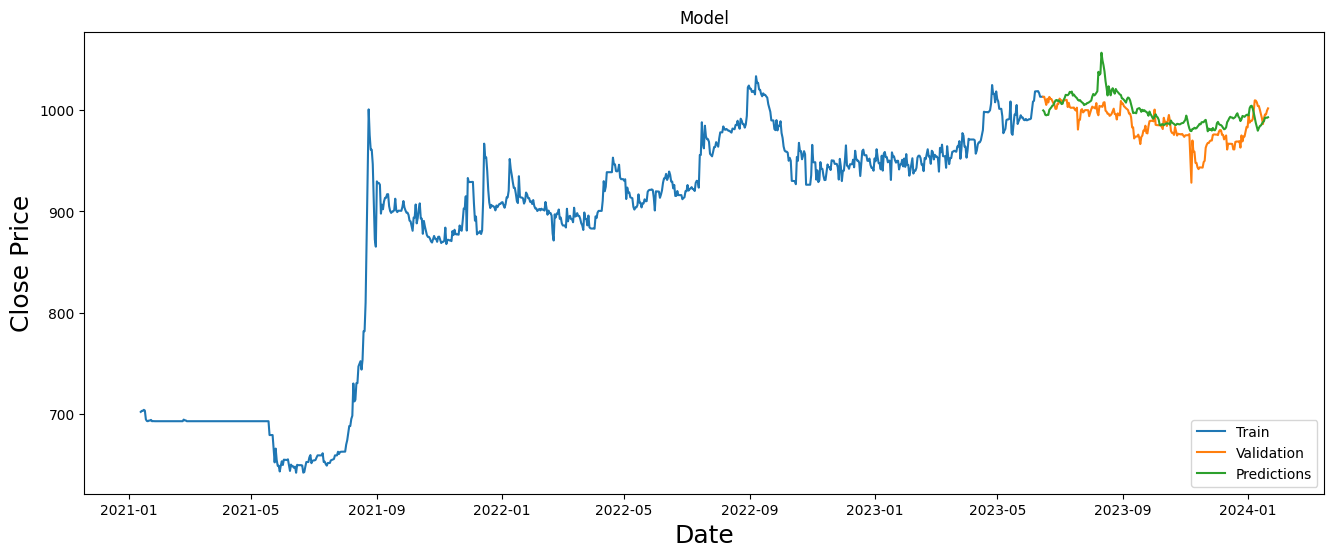

In [96]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# Apply GRU

1 day

In [108]:
GDF1 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_day
80
30
Epoch 1/80
30/30 [==============================] - 8s 17ms/step - loss: 0.0836
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0047
Epoch 3/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0026
Epoch 4/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0022
Epoch 5/80
30/30 [==============================] - 1s 16ms/step - loss: 0.0020
Epoch 6/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 7/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0018
Epoch 8/80
30/30 [==============================] - 1s 16ms/step - loss: 0.0018
Epoch 9/80
30/30 [==============================] - 1s 19ms/step - loss: 0.0017
Epoch 10/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0018
Epoch 11/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0017
Epoch 12/80
30/30 [====================

1 week

In [117]:
GDF7 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
1_week
80
30
Epoch 1/80
30/30 [==============================] - 7s 15ms/step - loss: 0.0458
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0063
Epoch 3/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0045
Epoch 4/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0041
Epoch 5/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0040
Epoch 6/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 7/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0040
Epoch 8/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 9/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 10/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 11/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 12/80
30/30 [===================

15 days

In [120]:
GDF15 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year']
15_days
80
30
Epoch 1/80
30/30 [==============================] - 8s 15ms/step - loss: 0.0633
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0090
Epoch 3/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0079
Epoch 4/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0075
Epoch 5/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0073
Epoch 6/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0071
Epoch 7/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0070
Epoch 8/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0070
Epoch 9/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 10/80
30/30 [==============================] - 1s 19ms/step - loss: 0.0067
Epoch 11/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0065
Epoch 12/80
30/30 [==================

1 month

# Apply XGboost

1 day

In [129]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,700.0,715.0,700.0,707.9,7739.0,3,1,2021,703.4,700.1,695.00,695.00,707.9,0.000000,0.000000,707.900000
1,2021-01-04,707.9,708.0,701.6,703.4,2284.0,4,1,2021,694.8,699.8,695.40,693.40,707.9,0.358974,0.071795,706.400000
2,2021-01-05,701.1,702.6,693.2,694.8,8977.0,5,1,2021,704.2,697.0,694.60,693.20,707.9,1.322171,0.321870,702.533333
3,2021-01-06,695.0,711.8,693.2,704.2,2668.0,6,1,2021,696.3,698.8,696.50,693.85,707.9,1.311887,0.519874,703.088889
4,2021-01-07,696.3,704.0,695.0,696.3,2362.0,7,1,2021,698.2,703.0,696.05,693.85,707.9,1.919079,0.799715,700.825926


Mean Squared Error: 65.52662094740528
Root Mean Squared Error: 8.094851508669278
R-squared: 0.7961417982420447


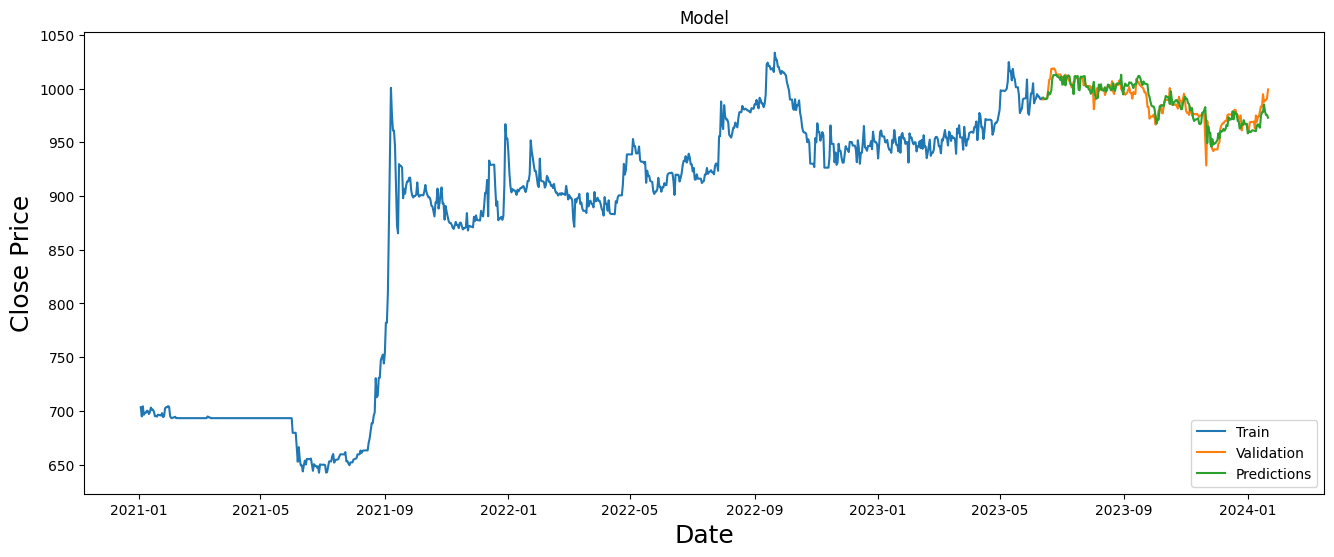

In [130]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

1 week

Mean Squared Error: 219.3063351002469
Root Mean Squared Error: 14.80899507394904
R-squared: 0.335056916932419


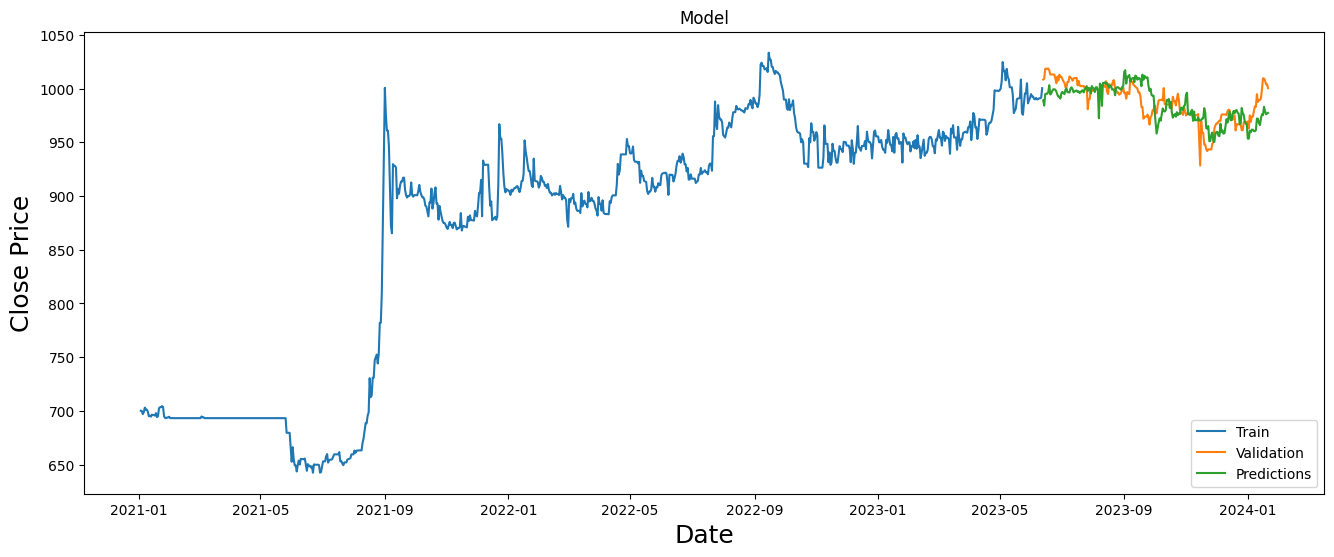

In [131]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

15 days

Mean Squared Error: 233.45367454828508
Root Mean Squared Error: 15.279190899661051
R-squared: 0.2322788330114759


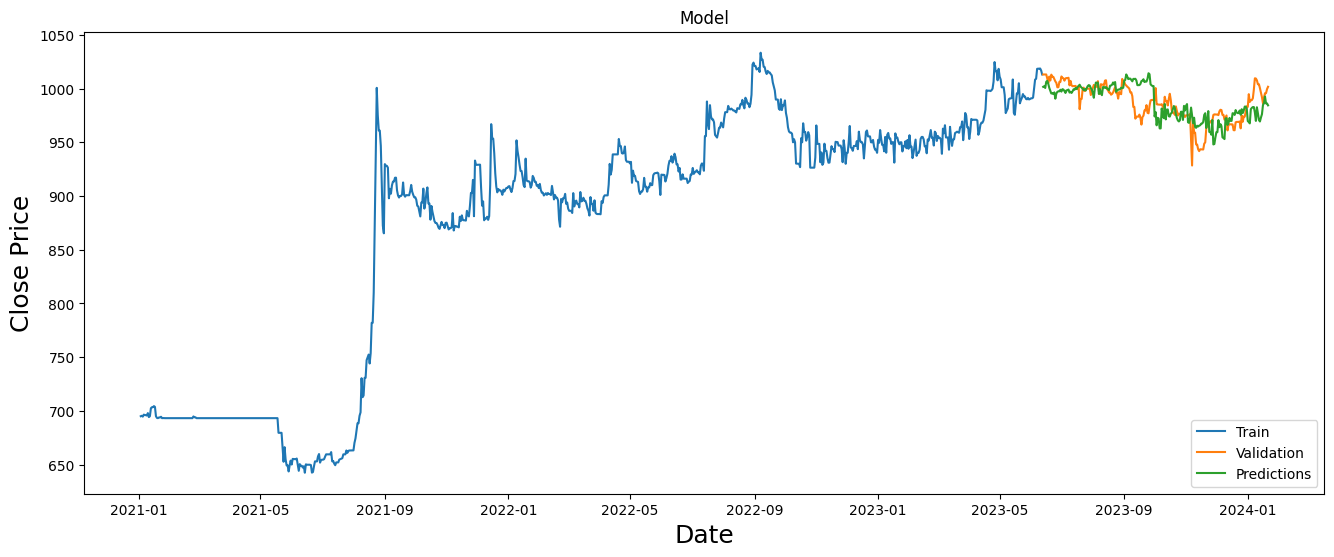

In [132]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

1 month

#  EMA

# Apply Random Forest

In [134]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,700.0,715.0,700.0,707.9,7739.0,3,1,2021,703.4,700.1,695.00,695.00,707.9,0.000000,0.000000,707.900000
1,2021-01-04,707.9,708.0,701.6,703.4,2284.0,4,1,2021,694.8,699.8,695.40,693.40,707.9,0.358974,0.071795,706.400000
2,2021-01-05,701.1,702.6,693.2,694.8,8977.0,5,1,2021,704.2,697.0,694.60,693.20,707.9,1.322171,0.321870,702.533333
3,2021-01-06,695.0,711.8,693.2,704.2,2668.0,6,1,2021,696.3,698.8,696.50,693.85,707.9,1.311887,0.519874,703.088889
4,2021-01-07,696.3,704.0,695.0,696.3,2362.0,7,1,2021,698.2,703.0,696.05,693.85,707.9,1.919079,0.799715,700.825926


Mean Squared Error: 53.549
Root Mean Squared Error: 7.318
R-squared Score: 0.833


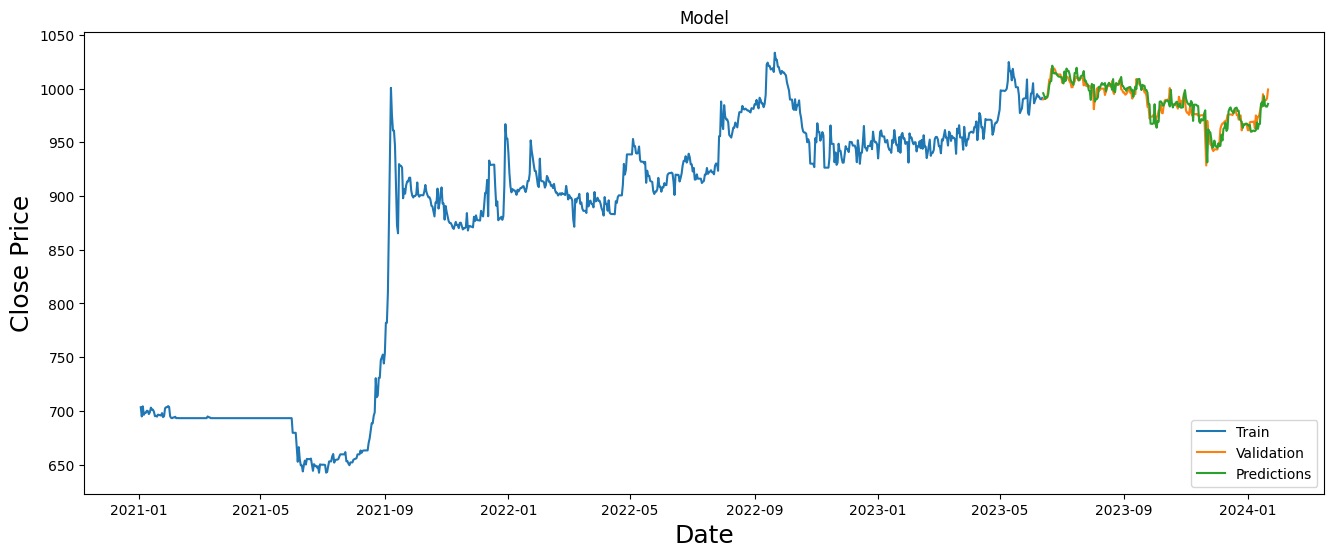

(53.549279430491644, 7.317737316308344, 0.8334042004257116)

In [135]:
RfDF1 = Dataset.copy()
n_estimators = 150
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)


Mean Squared Error: 182.370
Root Mean Squared Error: 13.504
R-squared Score: 0.447


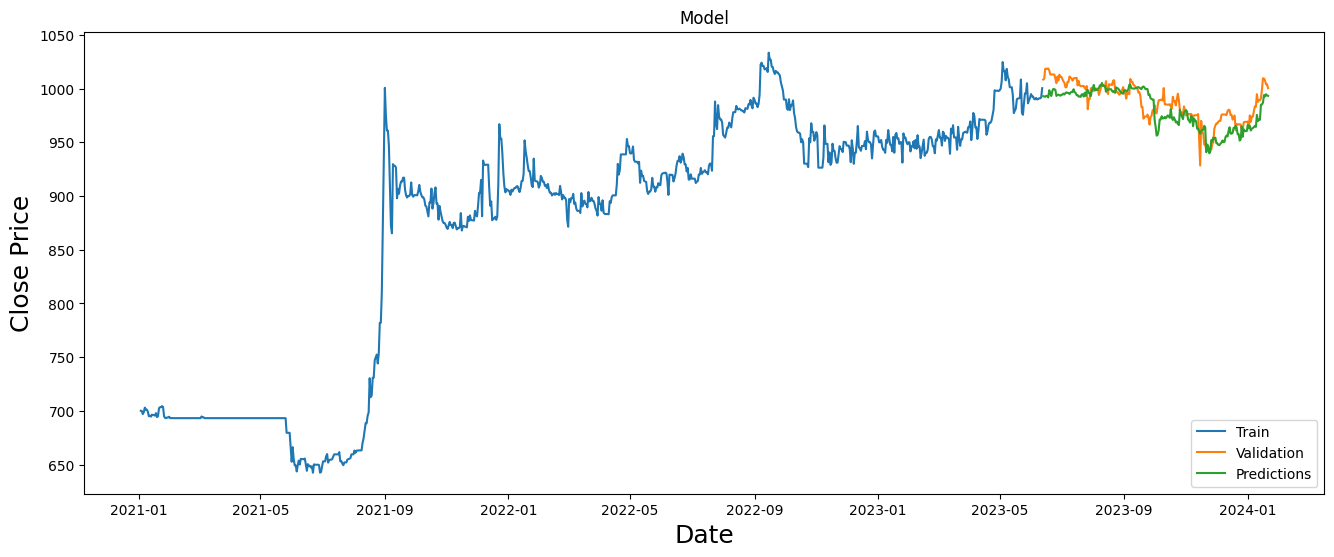

(182.37022391778675, 13.504452003609282, 0.44704826289588706)

In [136]:
RfDF7 = Dataset.copy()
n_estimators = 180
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

Mean Squared Error: 482.103
Root Mean Squared Error: 21.957
R-squared Score: -0.585


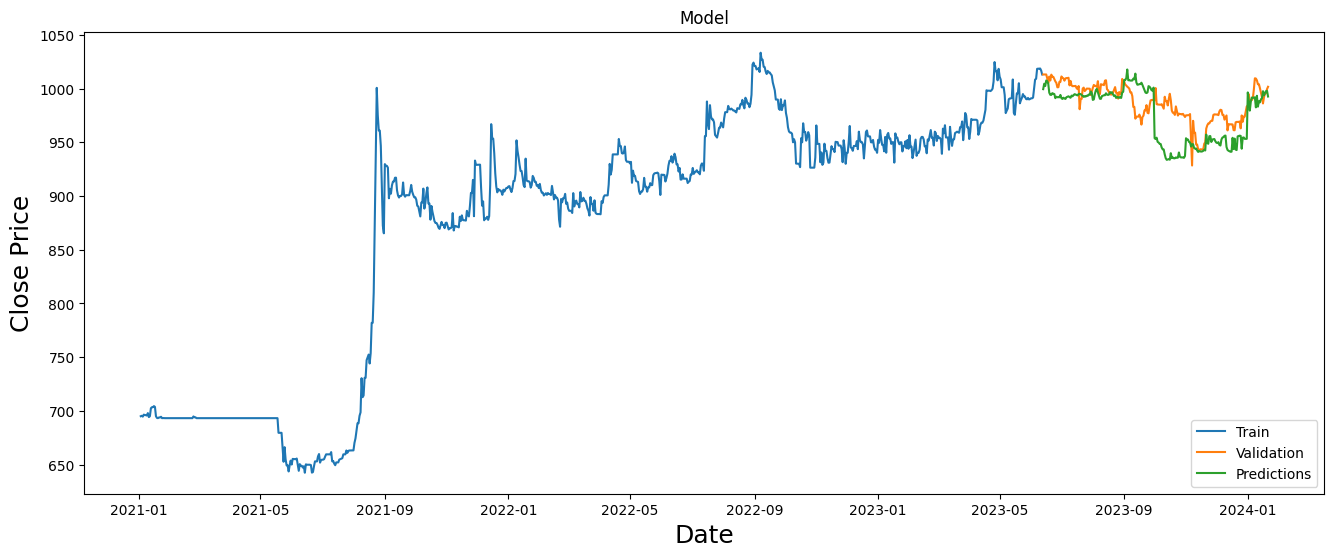

(482.1025114245026, 21.956832909700402, -0.5854121953534113)

In [139]:
RfDF15 = Dataset.copy()
n_estimators = 300
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

# Apply LSTM

In [166]:
LDF1 = Dataset.copy()
epochs = 90
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_day
90
40
Epoch 1/90
23/23 - 3s - loss: 0.2004 - 3s/epoch - 114ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0110 - 216ms/epoch - 9ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0048 - 185ms/epoch - 8ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0032 - 185ms/epoch - 8ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0027 - 185ms/epoch - 8ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0024 - 194ms/epoch - 8ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0023 - 185ms/epoch - 8ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0023 - 185ms/epoch - 8ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0021 - 185ms/epoch - 8ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0020 - 185ms/epoch - 8ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0020 - 185ms/epoch - 8ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0019 - 185ms/epoch - 8ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0018 - 178ms/epoch - 8ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0017 - 18

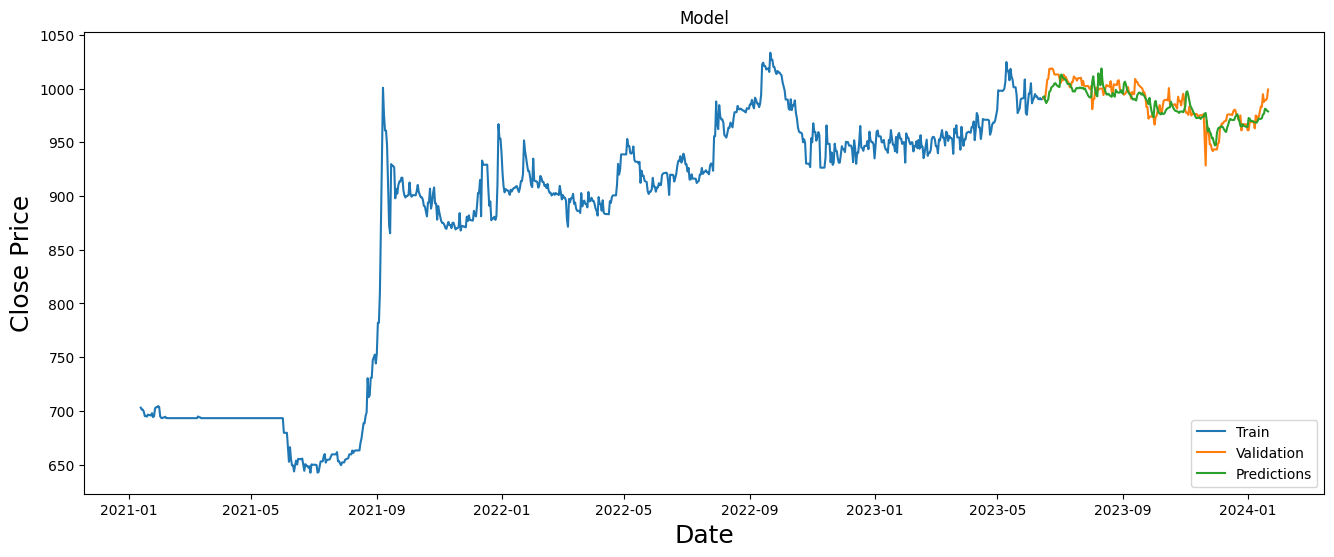

In [145]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)


In [146]:
LDF7 = Dataset.copy()
epochs = 120
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_week
120
40
Epoch 1/120
23/23 - 2s - loss: 0.0846 - 2s/epoch - 106ms/step
Epoch 2/120
23/23 - 0s - loss: 0.0101 - 185ms/epoch - 8ms/step
Epoch 3/120
23/23 - 0s - loss: 0.0061 - 201ms/epoch - 9ms/step
Epoch 4/120
23/23 - 0s - loss: 0.0049 - 185ms/epoch - 8ms/step
Epoch 5/120
23/23 - 0s - loss: 0.0045 - 185ms/epoch - 8ms/step
Epoch 6/120
23/23 - 0s - loss: 0.0041 - 178ms/epoch - 8ms/step
Epoch 7/120
23/23 - 0s - loss: 0.0039 - 185ms/epoch - 8ms/step
Epoch 8/120
23/23 - 0s - loss: 0.0033 - 185ms/epoch - 8ms/step
Epoch 9/120
23/23 - 0s - loss: 0.0030 - 185ms/epoch - 8ms/step
Epoch 10/120
23/23 - 0s - loss: 0.0027 - 185ms/epoch - 8ms/step
Epoch 11/120
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 12/120
23/23 - 0s - loss: 0.0023 - 185ms/epoch - 8ms/step
Epoch 13/120
23/23 - 0s - loss: 0.0021 - 194ms/epoch - 8ms/step
Epoch 14/120
23/23 - 0s - loss: 0.0021 - 185ms/epoch - 8ms/step
Epoch 15/120
23/23 - 0s - 

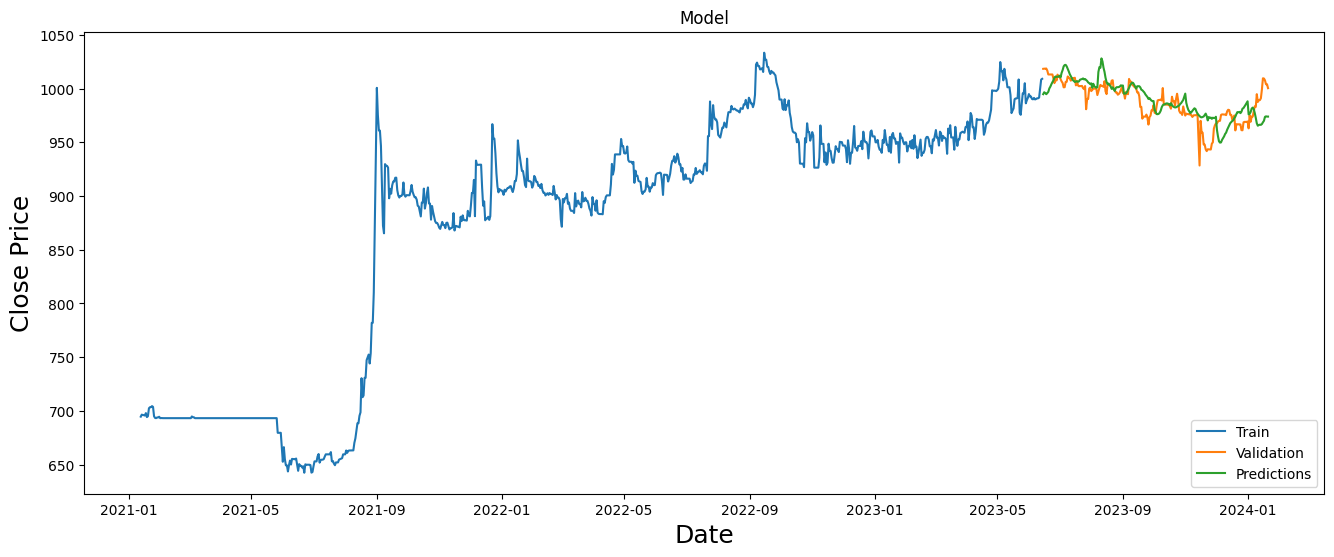

In [147]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [156]:
LDF15 = Dataset.copy()
epochs = 170
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
15_days
170
40
Epoch 1/170
23/23 - 3s - loss: 0.3013 - 3s/epoch - 113ms/step
Epoch 2/170
23/23 - 0s - loss: 0.0278 - 185ms/epoch - 8ms/step
Epoch 3/170
23/23 - 0s - loss: 0.0129 - 185ms/epoch - 8ms/step
Epoch 4/170
23/23 - 0s - loss: 0.0087 - 201ms/epoch - 9ms/step
Epoch 5/170
23/23 - 0s - loss: 0.0078 - 185ms/epoch - 8ms/step
Epoch 6/170
23/23 - 0s - loss: 0.0072 - 194ms/epoch - 8ms/step
Epoch 7/170
23/23 - 0s - loss: 0.0067 - 185ms/epoch - 8ms/step
Epoch 8/170
23/23 - 0s - loss: 0.0064 - 185ms/epoch - 8ms/step
Epoch 9/170
23/23 - 0s - loss: 0.0060 - 185ms/epoch - 8ms/step
Epoch 10/170
23/23 - 0s - loss: 0.0056 - 185ms/epoch - 8ms/step
Epoch 11/170
23/23 - 0s - loss: 0.0054 - 185ms/epoch - 8ms/step
Epoch 12/170
23/23 - 0s - loss: 0.0049 - 185ms/epoch - 8ms/step
Epoch 13/170
23/23 - 0s - loss: 0.0045 - 178ms/epoch - 8ms/step
Epoch 14/170
23/23 - 0s - loss: 0.0040 - 169ms/epoch - 7ms/step
Epoch 15/170
23/23 - 0s -

Epoch 128/170
23/23 - 0s - loss: 0.0013 - 216ms/epoch - 9ms/step
Epoch 129/170
23/23 - 0s - loss: 0.0012 - 263ms/epoch - 11ms/step
Epoch 130/170
23/23 - 0s - loss: 0.0014 - 238ms/epoch - 10ms/step
Epoch 131/170
23/23 - 0s - loss: 0.0013 - 232ms/epoch - 10ms/step
Epoch 132/170
23/23 - 0s - loss: 0.0012 - 216ms/epoch - 9ms/step
Epoch 133/170
23/23 - 0s - loss: 0.0013 - 185ms/epoch - 8ms/step
Epoch 134/170
23/23 - 0s - loss: 0.0014 - 185ms/epoch - 8ms/step
Epoch 135/170
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 136/170
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 137/170
23/23 - 0s - loss: 0.0012 - 185ms/epoch - 8ms/step
Epoch 138/170
23/23 - 0s - loss: 0.0013 - 185ms/epoch - 8ms/step
Epoch 139/170
23/23 - 0s - loss: 0.0011 - 178ms/epoch - 8ms/step
Epoch 140/170
23/23 - 0s - loss: 0.0013 - 185ms/epoch - 8ms/step
Epoch 141/170
23/23 - 0s - loss: 0.0020 - 185ms/epoch - 8ms/step
Epoch 142/170
23/23 - 0s - loss: 0.0015 - 185ms/epoch - 8ms/step
Epoch 143/170
23/23 - 

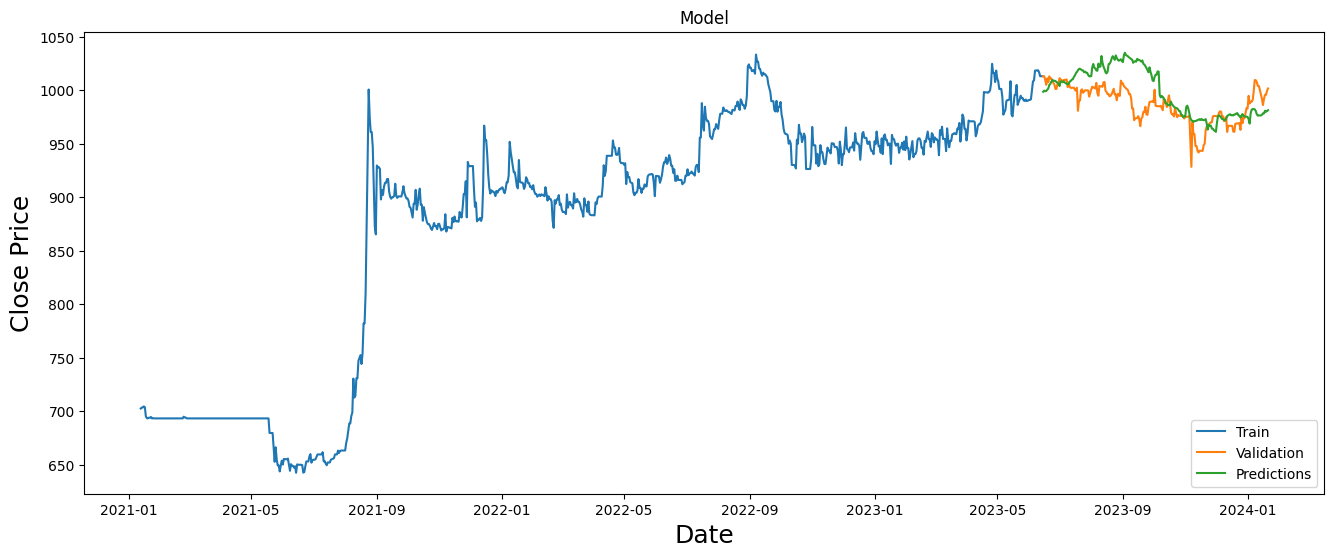

In [157]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# GRU

In [168]:
GDF1 = Dataset.copy()
epochs = 90
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_day
90
30
Epoch 1/90
30/30 [==============================] - 7s 16ms/step - loss: 0.0127
Epoch 2/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0023
Epoch 3/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0019
Epoch 4/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0017
Epoch 5/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 6/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 7/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 8/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0016
Epoch 9/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0014
Epoch 10/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0014
Epoch 11/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0016
Epoch 12/90
30/30 [=============

In [169]:
GDF7 = Dataset.copy()
epochs = 90
batch_size = 30
Features =  ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
1_week
90
30
Epoch 1/90
30/30 [==============================] - 7s 16ms/step - loss: 0.0384
Epoch 2/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0053
Epoch 3/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0042
Epoch 4/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0041
Epoch 5/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0040
Epoch 6/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0039
Epoch 7/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 8/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0040
Epoch 9/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0038
Epoch 10/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0038
Epoch 11/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0038
Epoch 12/90
30/30 [============

In [171]:
GDF15 = Dataset.copy()
epochs = 80
batch_size = 30
Features =  ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'ema']
15_days
80
30
Epoch 1/80
30/30 [==============================] - 7s 16ms/step - loss: 0.0703
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0088
Epoch 3/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0072
Epoch 4/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 5/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0068
Epoch 6/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0068
Epoch 7/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0066
Epoch 8/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0066
Epoch 9/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 10/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0064
Epoch 11/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 12/80
30/30 [===========

# XGBoost

Mean Squared Error: 53.1458217792407
Root Mean Squared Error: 7.290118090898164
R-squared: 0.834659387250247


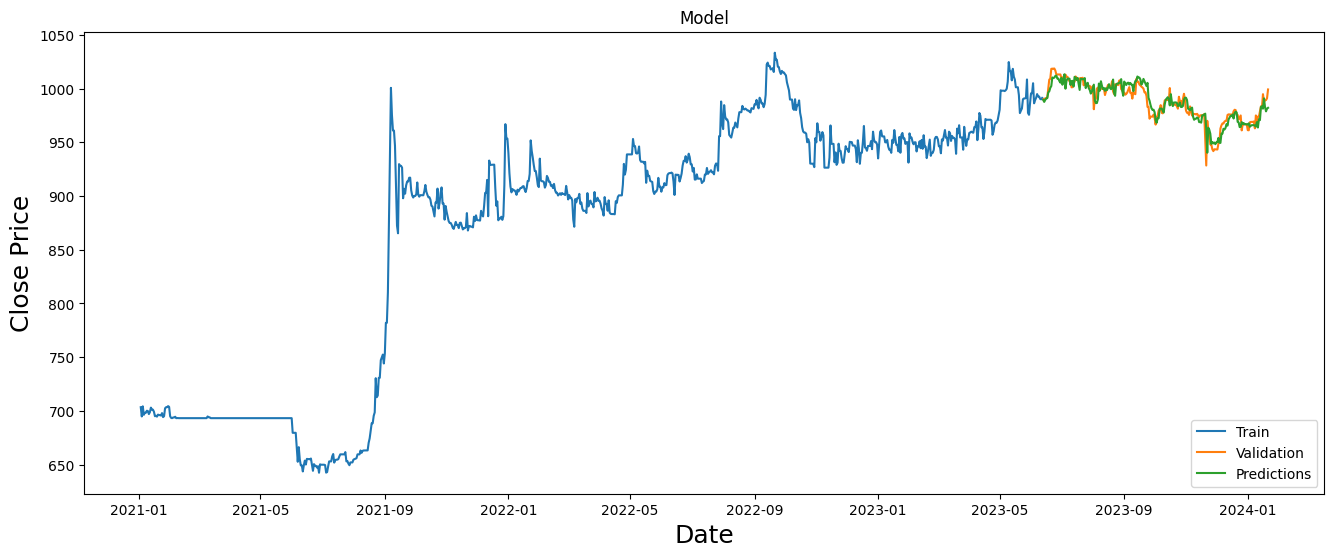

In [172]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

Mean Squared Error: 191.71023387545358
Root Mean Squared Error: 13.845946478137693
R-squared: 0.4187290854571962


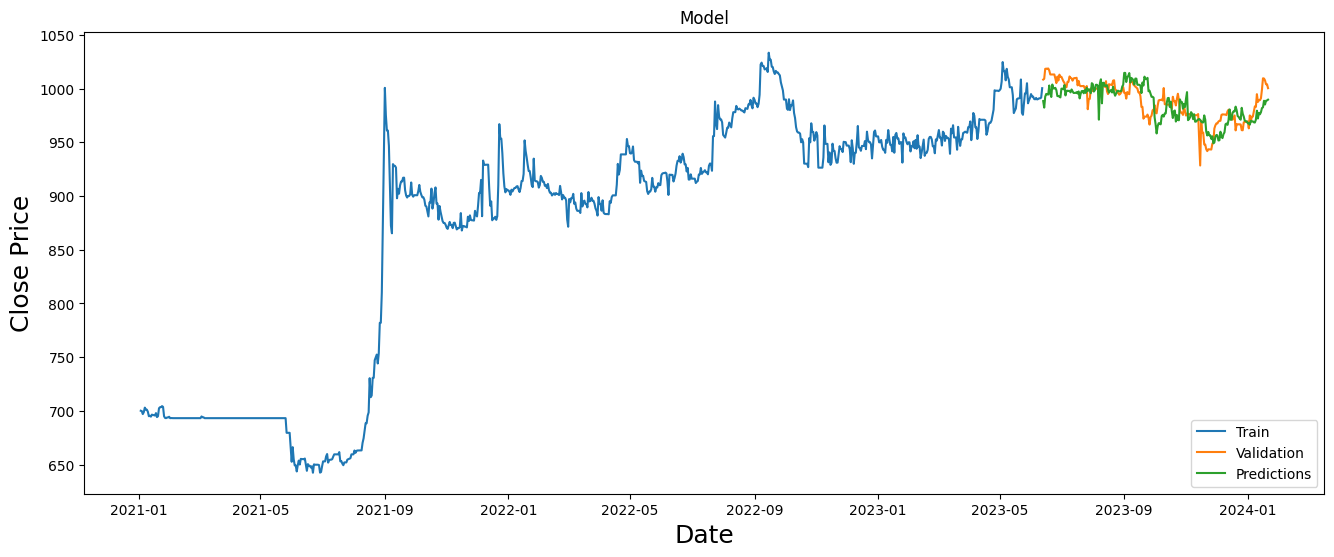

In [173]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

Mean Squared Error: 227.64779339120193
Root Mean Squared Error: 15.088001636770919
R-squared: 0.2513716910096937


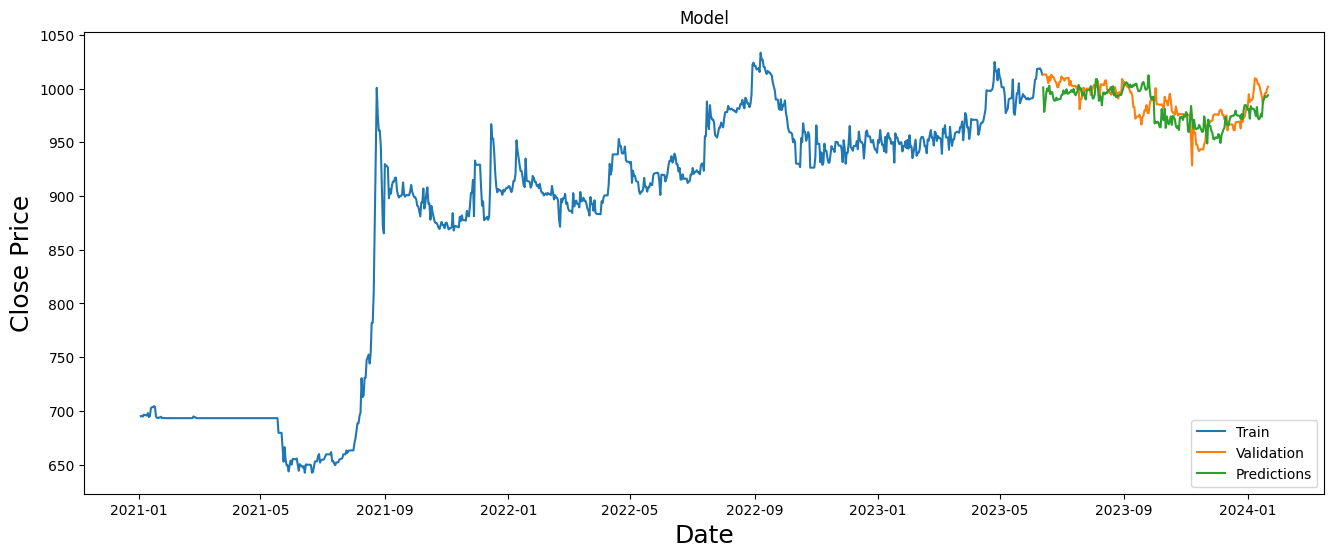

In [174]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','ema']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

# With SMA_7, MACD, ema

Mean Squared Error: 50.913
Root Mean Squared Error: 7.135
R-squared Score: 0.842


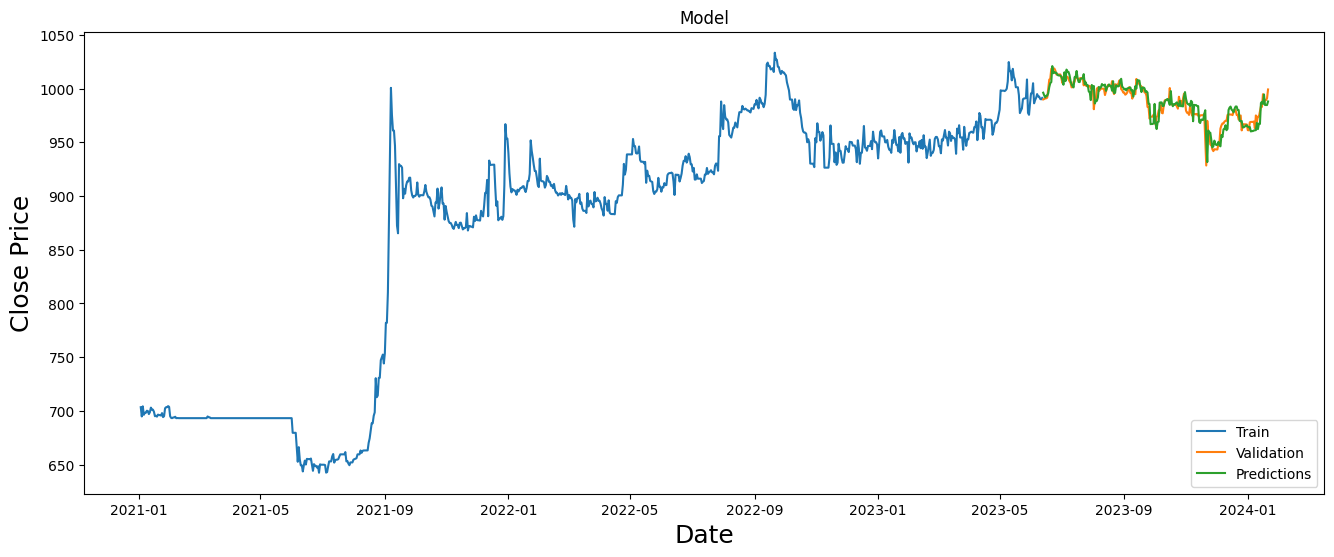

(50.912782540108566, 7.135319371976882, 0.841606538761536)

In [175]:
RfDF1 = Dataset.copy()
n_estimators = 150
random_state = 15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_day'
run_random_forest(RfDF1, n_estimators, random_state,features, target)

Mean Squared Error: 220.877
Root Mean Squared Error: 14.862
R-squared Score: 0.330


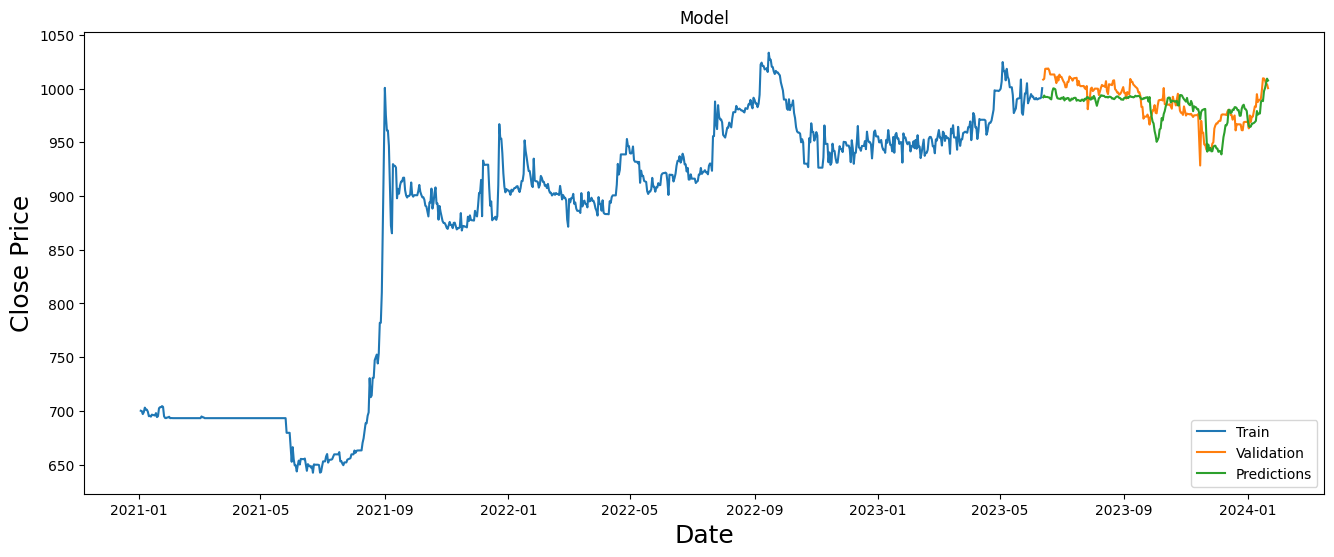

(220.87709656451605, 14.861934482580525, 0.33029432322833185)

In [188]:
RfDF7 = Dataset.copy()
n_estimators = 160
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_week'
run_random_forest(RfDF7, n_estimators, random_state,features, target)

Mean Squared Error: 411.020
Root Mean Squared Error: 20.274
R-squared Score: -0.352


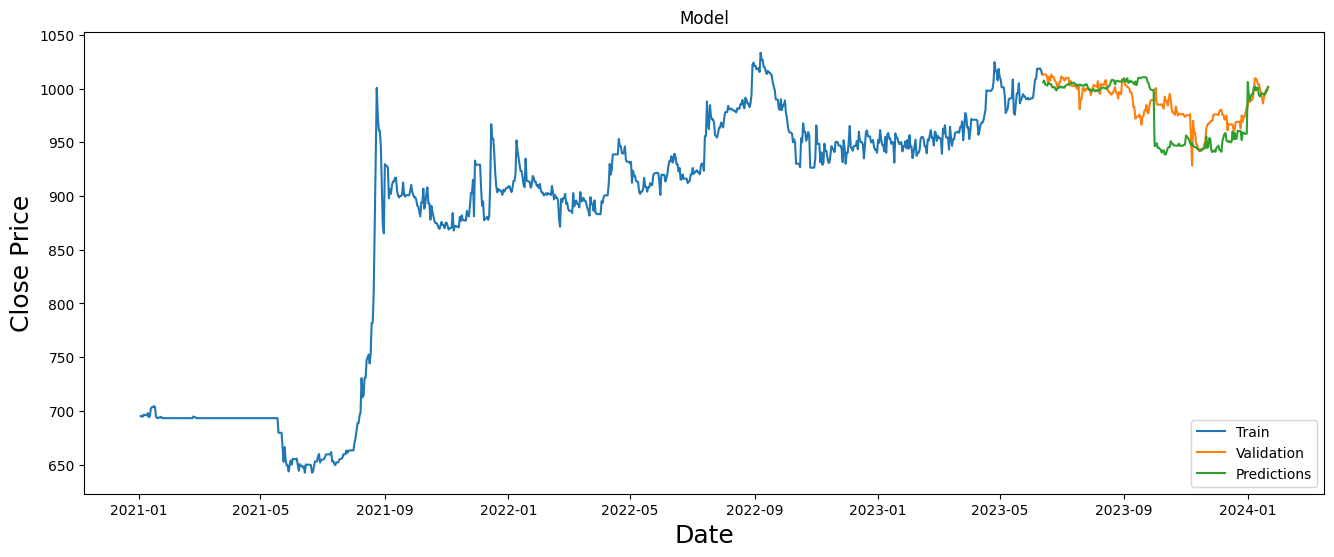

(411.01988077129005, 20.273625249848386, -0.3516542977178718)

In [189]:
RfDF15 = Dataset.copy()
n_estimators = 300
random_state =15
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '15_days'
run_random_forest(RfDF15, n_estimators, random_state,features, target)

In [190]:
LDF1 = Dataset.copy()
epochs = 90
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_day'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF1,features,target, epochs, batch_size)


['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_day
90
40
Epoch 1/90
23/23 - 2s - loss: 0.0512 - 2s/epoch - 105ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0050 - 185ms/epoch - 8ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0029 - 185ms/epoch - 8ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0024 - 185ms/epoch - 8ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0022 - 178ms/epoch - 8ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0020 - 185ms/epoch - 8ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0019 - 185ms/epoch - 8ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0018 - 169ms/epoch - 7ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0017 - 169ms/epoch - 7ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0016 - 194ms/epoch - 8ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0015 - 185ms/epoch - 8ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0015 - 169ms/epoch - 7ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0015 - 185ms/epoch - 8ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0014 - 185ms/epoch - 8ms/step
Epoch 15/90
23/23 - 0s - 

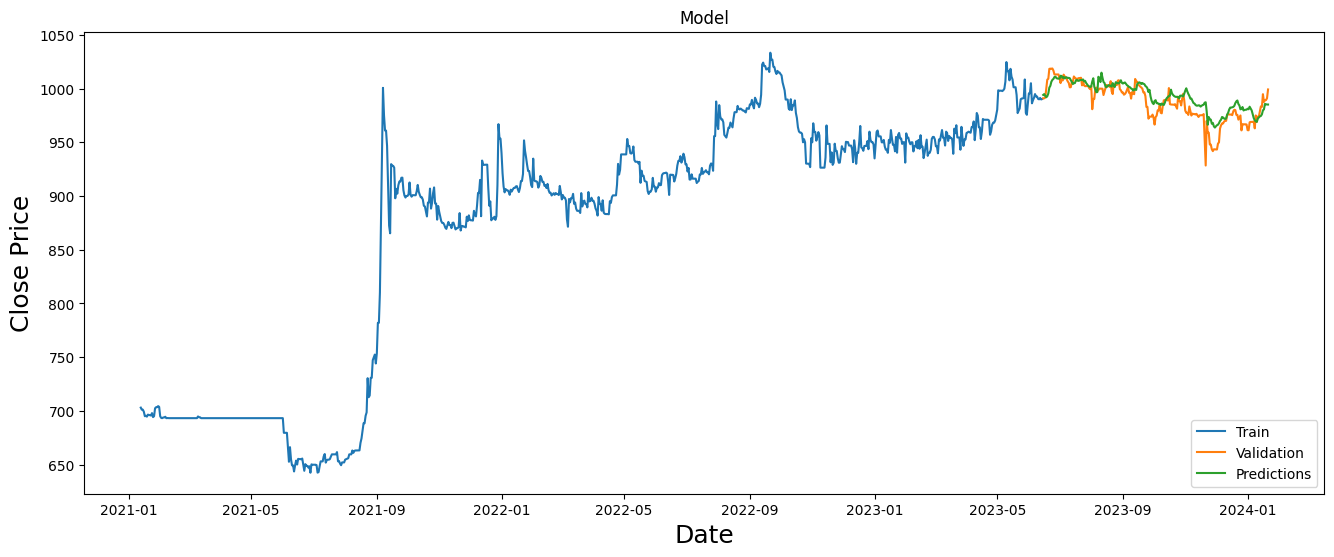

In [191]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [203]:
LDF7 = Dataset.copy()
epochs = 110
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '1_week'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF7,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_week
110
40
Epoch 1/110
23/23 - 2s - loss: 0.0783 - 2s/epoch - 107ms/step
Epoch 2/110
23/23 - 0s - loss: 0.0078 - 201ms/epoch - 9ms/step
Epoch 3/110
23/23 - 0s - loss: 0.0051 - 201ms/epoch - 9ms/step
Epoch 4/110
23/23 - 0s - loss: 0.0043 - 185ms/epoch - 8ms/step
Epoch 5/110
23/23 - 0s - loss: 0.0038 - 185ms/epoch - 8ms/step
Epoch 6/110
23/23 - 0s - loss: 0.0035 - 201ms/epoch - 9ms/step
Epoch 7/110
23/23 - 0s - loss: 0.0033 - 185ms/epoch - 8ms/step
Epoch 8/110
23/23 - 0s - loss: 0.0032 - 185ms/epoch - 8ms/step
Epoch 9/110
23/23 - 0s - loss: 0.0030 - 201ms/epoch - 9ms/step
Epoch 10/110
23/23 - 0s - loss: 0.0030 - 201ms/epoch - 9ms/step
Epoch 11/110
23/23 - 0s - loss: 0.0026 - 185ms/epoch - 8ms/step
Epoch 12/110
23/23 - 0s - loss: 0.0026 - 201ms/epoch - 9ms/step
Epoch 13/110
23/23 - 0s - loss: 0.0026 - 201ms/epoch - 9ms/step
Epoch 14/110
23/23 - 0s - loss: 0.0024 - 201ms/epoch - 9ms/step
Epoch 15/

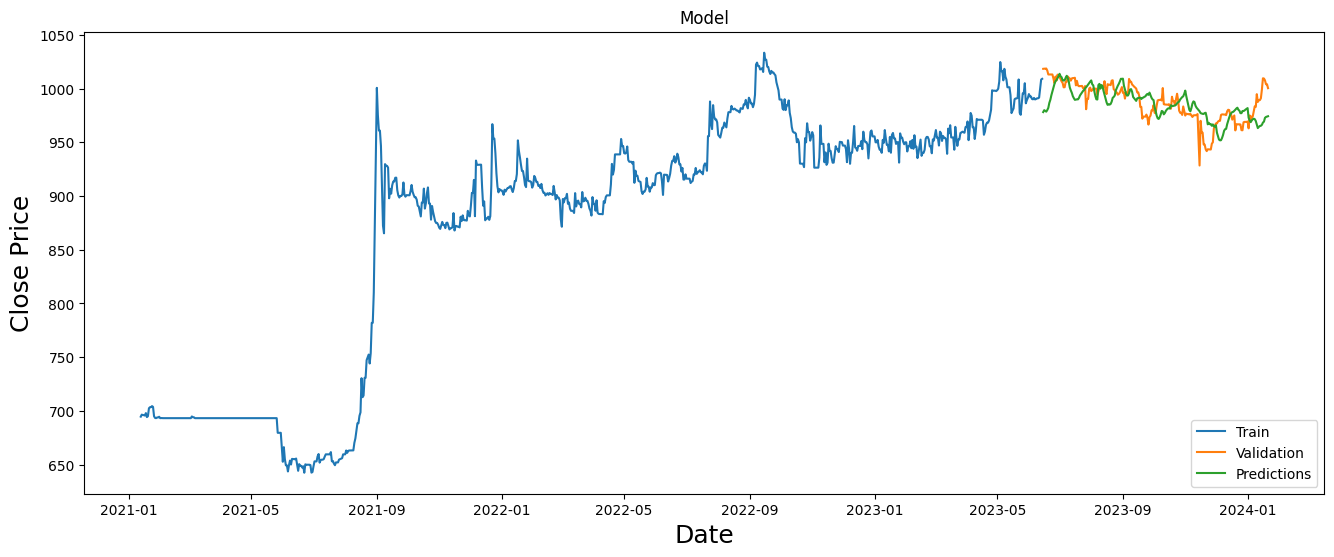

In [204]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

In [207]:
LDF15 = Dataset.copy()
epochs = 150
batch_size = 40
features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
target = '15_days'
train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv=LSTM_Model(LDF15,features,target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
15_days
150
40
Epoch 1/150
23/23 - 2s - loss: 0.1826 - 2s/epoch - 107ms/step
Epoch 2/150
23/23 - 0s - loss: 0.0173 - 185ms/epoch - 8ms/step
Epoch 3/150
23/23 - 0s - loss: 0.0116 - 201ms/epoch - 9ms/step
Epoch 4/150
23/23 - 0s - loss: 0.0105 - 201ms/epoch - 9ms/step
Epoch 5/150
23/23 - 0s - loss: 0.0092 - 185ms/epoch - 8ms/step
Epoch 6/150
23/23 - 0s - loss: 0.0079 - 185ms/epoch - 8ms/step
Epoch 7/150
23/23 - 0s - loss: 0.0076 - 201ms/epoch - 9ms/step
Epoch 8/150
23/23 - 0s - loss: 0.0065 - 185ms/epoch - 8ms/step
Epoch 9/150
23/23 - 0s - loss: 0.0063 - 194ms/epoch - 8ms/step
Epoch 10/150
23/23 - 0s - loss: 0.0058 - 178ms/epoch - 8ms/step
Epoch 11/150
23/23 - 0s - loss: 0.0053 - 201ms/epoch - 9ms/step
Epoch 12/150
23/23 - 0s - loss: 0.0050 - 223ms/epoch - 10ms/step
Epoch 13/150
23/23 - 0s - loss: 0.0046 - 247ms/epoch - 11ms/step
Epoch 14/150
23/23 - 0s - loss: 0.0041 - 238ms/epoch - 10ms/step
Epoch

23/23 - 0s - loss: 0.0019 - 201ms/epoch - 9ms/step
Epoch 128/150
23/23 - 0s - loss: 0.0017 - 247ms/epoch - 11ms/step
Epoch 129/150
23/23 - 0s - loss: 0.0016 - 185ms/epoch - 8ms/step
Epoch 130/150
23/23 - 0s - loss: 0.0020 - 201ms/epoch - 9ms/step
Epoch 131/150
23/23 - 0s - loss: 0.0016 - 201ms/epoch - 9ms/step
Epoch 132/150
23/23 - 0s - loss: 0.0016 - 201ms/epoch - 9ms/step
Epoch 133/150
23/23 - 0s - loss: 0.0015 - 185ms/epoch - 8ms/step
Epoch 134/150
23/23 - 0s - loss: 0.0017 - 185ms/epoch - 8ms/step
Epoch 135/150
23/23 - 0s - loss: 0.0016 - 185ms/epoch - 8ms/step
Epoch 136/150
23/23 - 0s - loss: 0.0016 - 201ms/epoch - 9ms/step
Epoch 137/150
23/23 - 0s - loss: 0.0016 - 185ms/epoch - 8ms/step
Epoch 138/150
23/23 - 0s - loss: 0.0016 - 185ms/epoch - 8ms/step
Epoch 139/150
23/23 - 0s - loss: 0.0016 - 194ms/epoch - 8ms/step
Epoch 140/150
23/23 - 0s - loss: 0.0016 - 185ms/epoch - 8ms/step
Epoch 141/150
23/23 - 0s - loss: 0.0016 - 201ms/epoch - 9ms/step
Epoch 142/150
23/23 - 0s - loss: 0.001

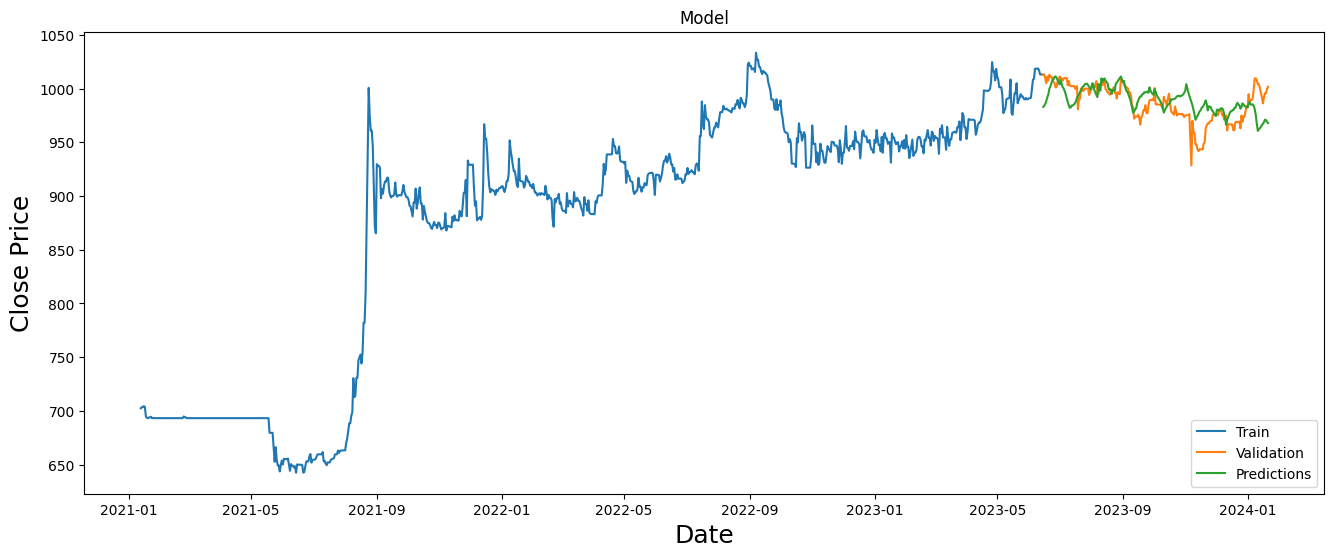

In [208]:
linegraph(train_dates, train_inv_y, test_dates, y_test_inv, y_pred_inv)

# GRU

In [209]:
GDF1 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
GRU_Model(GDF1,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_day
80
30
Epoch 1/80
30/30 [==============================] - 8s 17ms/step - loss: 0.0444
Epoch 2/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 3/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0021
Epoch 4/80
30/30 [==============================] - 1s 16ms/step - loss: 0.0019
Epoch 5/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0018
Epoch 6/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0018
Epoch 7/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0017
Epoch 8/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0016
Epoch 9/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0016
Epoch 10/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 11/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0015
Epoch 12/80
30/

In [215]:
GDF7 = Dataset.copy()
epochs = 80
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
GRU_Model(GDF7,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
1_week
80
30
Epoch 1/80
30/30 [==============================] - 7s 16ms/step - loss: 0.0265
Epoch 2/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0052
Epoch 3/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0040
Epoch 4/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 5/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 6/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0037
Epoch 7/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0036
Epoch 8/80
30/30 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 9/80
30/30 [==============================] - 1s 18ms/step - loss: 0.0035
Epoch 10/80
30/30 [==============================] - 1s 17ms/step - loss: 0.0036
Epoch 11/80
30/30 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 12/80
30

In [223]:
GDF15 = Dataset.copy()
epochs = 90
batch_size = 30
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
GRU_Model(GDF15,Features, Target, epochs, batch_size)

['Open', 'High', 'Low', 'Close', 'Volume', 'day', 'month', 'year', 'SMA_7', 'MACD', 'ema']
15_days
90
30
Epoch 1/90
30/30 [==============================] - 7s 16ms/step - loss: 0.0546
Epoch 2/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0101
Epoch 3/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0081
Epoch 4/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0077
Epoch 5/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 6/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0069
Epoch 7/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 8/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0067
Epoch 9/90
30/30 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 10/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0064
Epoch 11/90
30/30 [==============================] - 0s 15ms/step - loss: 0.0060
Epoch 12/90
3

# XGBoost

Mean Squared Error: 47.02662831849514
Root Mean Squared Error: 6.857596395129648
R-squared: 0.8536966541973384


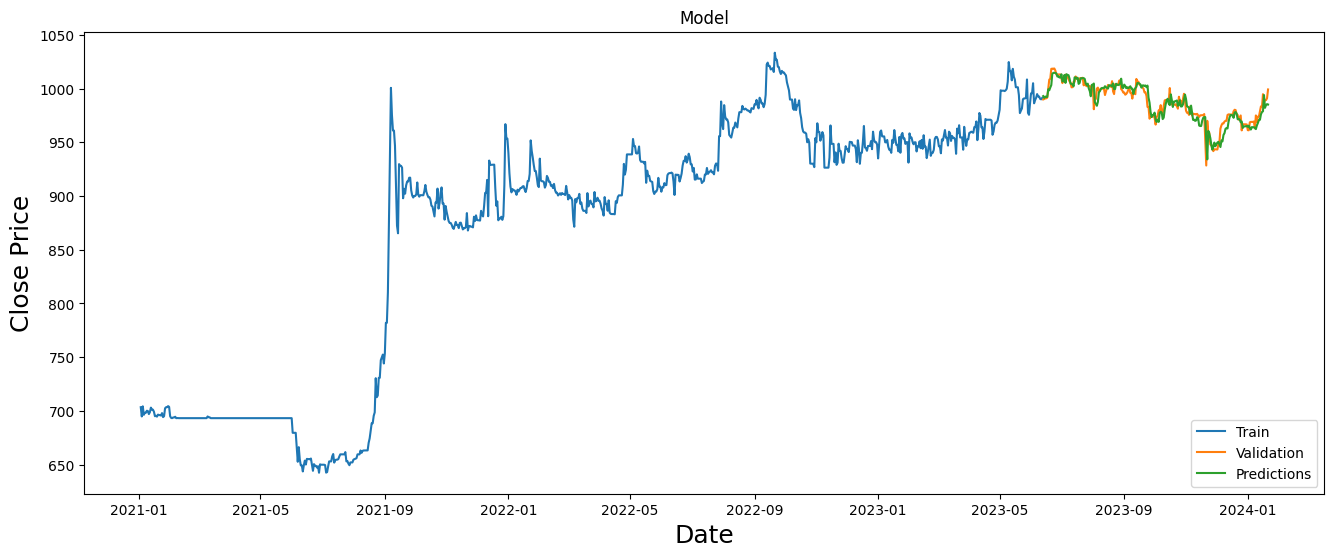

In [227]:
XDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
run_xgboost(XDF1, Features, Target, random_state)

Mean Squared Error: 216.55310187656448
Root Mean Squared Error: 14.715743334149467
R-squared: 0.3434047988452814


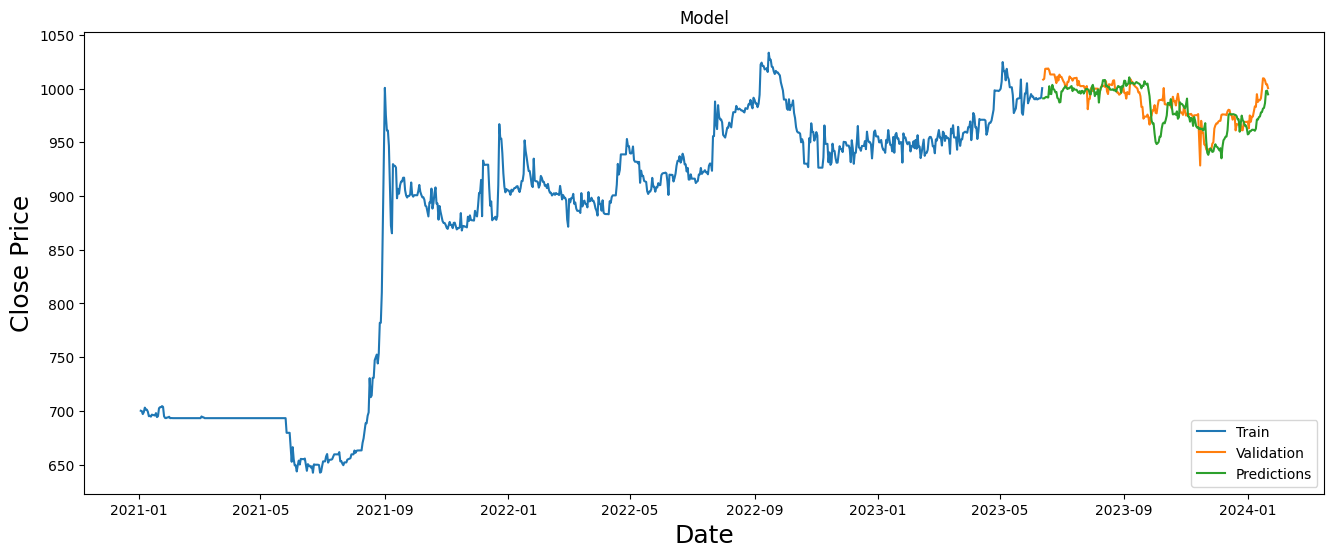

In [228]:
XDF7 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
run_xgboost(XDF7, Features, Target, random_state)

Mean Squared Error: 260.38325411120934
Root Mean Squared Error: 16.136395325821976
R-squared: 0.14371990033002668


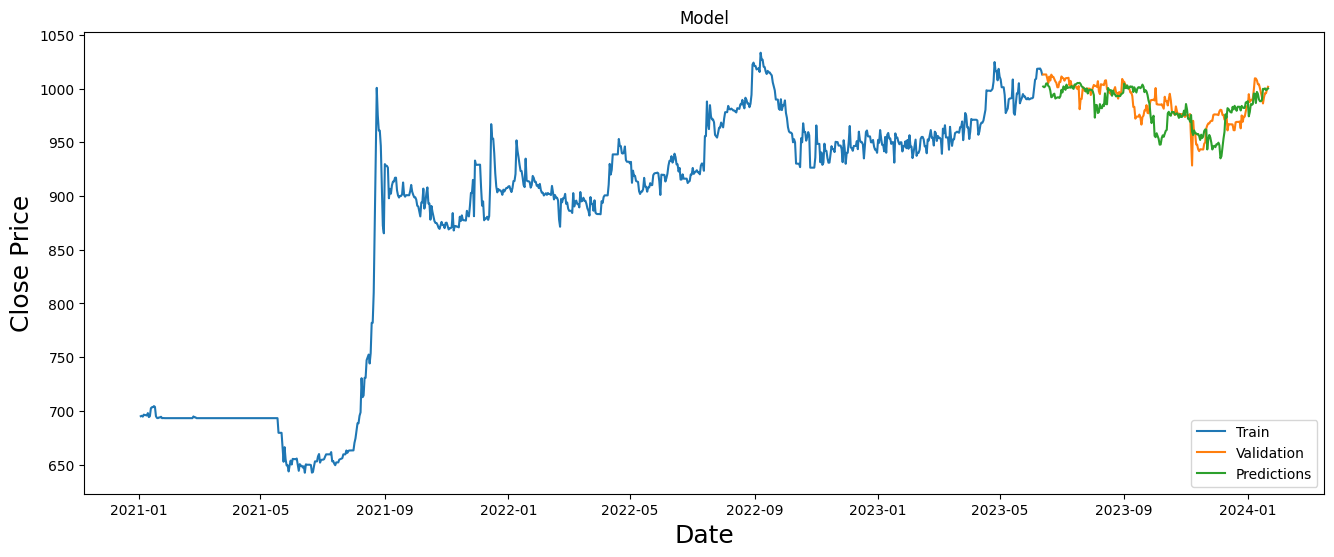

In [229]:
XDF15 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
run_xgboost(XDF15, Features, Target, random_state)

# Ensebled Algorithm

# Splitting Data

In [381]:
Dataset.head()

,Date,Open,High,Low,Close,Volume,day,month,year,1_day,1_week,15_days,1_month,SMA_7,MACD,Signal_Line,ema
0,2021-01-03,700.0,715.0,700.0,707.9,7739.0,3,1,2021,703.4,700.1,695.00,695.00,707.9,0.000000,0.000000,707.900000
1,2021-01-04,707.9,708.0,701.6,703.4,2284.0,4,1,2021,694.8,699.8,695.40,693.40,707.9,0.358974,0.071795,706.400000
2,2021-01-05,701.1,702.6,693.2,694.8,8977.0,5,1,2021,704.2,697.0,694.60,693.20,707.9,1.322171,0.321870,702.533333
3,2021-01-06,695.0,711.8,693.2,704.2,2668.0,6,1,2021,696.3,698.8,696.50,693.85,707.9,1.311887,0.519874,703.088889
4,2021-01-07,696.3,704.0,695.0,696.3,2362.0,7,1,2021,698.2,703.0,696.05,693.85,707.9,1.919079,0.799715,700.825926


In [389]:
def split_dataset(Feat, Tar, ran_state):
    Features = Feat
    Target = Tar
    random = ran_state
    X_train, X_test, y_train, y_test = train_test_split(
        Features,
        Target,
        test_size=0.2,
        random_state=random,
        shuffle=False
    )
    return X_train, X_test, y_train, y_test

In [390]:
def create_sequences(DF, sequence_length):
    X, y = [], []
    for i in range(len(DF) - sequence_length):
        X.append(DF[i:(i + sequence_length), :-1])
        y.append(DF[i + sequence_length, -1])
    X, y = np.array(X), np.array(y)
    return X, y.reshape(-1,1)

In [529]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt, mean, array
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
import numpy as np

def LSTM_Model(X_train, X_test, y_train, epochs, batch_size, scaler):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :]
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    return y_pred_inv

def GRU_Model(X_train, X_test, y_train, epochs, batch_size, scaler):
    model = Sequential()
    model.add(GRU(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)
    y_pred = model.predict(X_test)
    X_test_reshaped = X_test[:, -1, :]
    y_pred_inv = scaler.inverse_transform(np.concatenate((X_test_reshaped, y_pred), axis=1))[:, -1]
    return y_pred_inv

def random_forest_model(X_train, X_test, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def xgboost_model(X_train, X_test, y_train):
    model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def ensemble_model(EDF1, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state):
    from sklearn.metrics import mean_squared_error
    from numpy import sqrt, mean, array
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    import xgboost as xgb
    from keras.models import Sequential
    from keras.layers import LSTM, GRU, Dense
    import numpy as np

    # Prepare and scale data
    scaler = MinMaxScaler()
    DF_scaled = scaler.fit_transform(EDF1[Features + [Target]])
    X_seq, y_seq = create_sequences(DF_scaled, sequence_length)

    X_train, X_test, y_train, y_test = split_dataset(X_seq, y_seq, random_state)
    X_train1, X_test1, y_train1, y_test1 = split_dataset(EDF1[Features], EDF1[Target], random_state)
    # Reshape for RF and XGB: taking the last timestep of each sequence
    X_train_last = X_train[:, -1, :]
    X_test_last = X_test[:, -1, :]
    
    # Train and predict with each model
    lstm_predictions = LSTM_Model(X_train, X_test, y_train, epochs, batch_size, scaler)
    gru_predictions = GRU_Model(X_train, X_test, y_train, epochs, batch_size, scaler)
    rf_predictions = random_forest_model(X_train1, X_test1, y_train1)
    xgb_predictions = xgboost_model(X_train1, X_test1,y_train1)
   
    # Inverse transform y_test and predictions to original scale
    # y_test_original = scaler.inverse_transform(np.concatenate((X_test_last, y_test), axis=1))[:, -1]
    # Ensure all predictions are in the original scale
    average_predictions = mean(array([lstm_predictions, gru_predictions, rf_predictions, xgb_predictions]), axis=0)
    # Calculate RMSE
    mse = mean_squared_error(y_test1, average_predictions)
    rmse = sqrt(mse)
    return rmse

In [530]:
EDF1 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_day'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF1, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.2517 - 2s/epoch - 102ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0197 - 85ms/epoch - 4ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0050 - 100ms/epoch - 4ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0025 - 85ms/epoch - 4ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0019 - 100ms/epoch - 4ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0018 - 85ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0017 - 100ms/epoch - 4ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0016 - 85ms/epoch - 4ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0016 - 100ms/epoch - 4ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0015 - 94ms/epoch - 4ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0015 - 85ms/epoch - 4ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0014 - 100ms/epoch - 4ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0014 - 85ms/epoch - 4ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0014 - 100ms/epoch - 4ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0014 - 85ms/epoch - 4ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0014 - 100ms/epoch - 4ms/step
Epoch 17/9

Epoch 41/90
23/23 - 0s - loss: 9.7990e-04 - 94ms/epoch - 4ms/step
Epoch 42/90
23/23 - 0s - loss: 9.9629e-04 - 78ms/epoch - 3ms/step
Epoch 43/90
23/23 - 0s - loss: 9.6647e-04 - 85ms/epoch - 4ms/step
Epoch 44/90
23/23 - 0s - loss: 9.4938e-04 - 69ms/epoch - 3ms/step
Epoch 45/90
23/23 - 0s - loss: 9.4162e-04 - 69ms/epoch - 3ms/step
Epoch 46/90
23/23 - 0s - loss: 9.2776e-04 - 85ms/epoch - 4ms/step
Epoch 47/90
23/23 - 0s - loss: 9.1944e-04 - 94ms/epoch - 4ms/step
Epoch 48/90
23/23 - 0s - loss: 9.1474e-04 - 85ms/epoch - 4ms/step
Epoch 49/90
23/23 - 0s - loss: 8.9445e-04 - 69ms/epoch - 3ms/step
Epoch 50/90
23/23 - 0s - loss: 8.9834e-04 - 69ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 8.9817e-04 - 85ms/epoch - 4ms/step
Epoch 52/90
23/23 - 0s - loss: 8.7424e-04 - 85ms/epoch - 4ms/step
Epoch 53/90
23/23 - 0s - loss: 8.5245e-04 - 94ms/epoch - 4ms/step
Epoch 54/90
23/23 - 0s - loss: 8.5547e-04 - 69ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 8.8888e-04 - 69ms/epoch - 3ms/step
Epoch 56/9

In [531]:
EDF2 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_week'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF2, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.3817 - 2s/epoch - 109ms/step
Epoch 2/90
23/23 - 0s - loss: 0.1489 - 85ms/epoch - 4ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0231 - 85ms/epoch - 4ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0110 - 78ms/epoch - 3ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0076 - 85ms/epoch - 4ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0057 - 85ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0049 - 85ms/epoch - 4ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0047 - 69ms/epoch - 3ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0046 - 85ms/epoch - 4ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0044 - 78ms/epoch - 3ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0043 - 78ms/epoch - 3ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0042 - 85ms/epoch - 4ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0042 - 85ms/epoch - 4ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0041 - 100ms/epoch - 4ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0040 - 100ms/epoch - 4ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0039 - 85ms/epoch - 4ms/step
Epoch 17/90
23/

Epoch 43/90
23/23 - 0s - loss: 0.0025 - 85ms/epoch - 4ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0024 - 69ms/epoch - 3ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0024 - 85ms/epoch - 4ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0024 - 63ms/epoch - 3ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0024 - 85ms/epoch - 4ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0023 - 69ms/epoch - 3ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0023 - 85ms/epoch - 4ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0023 - 78ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0023 - 69ms/epoch - 3ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0023 - 69ms/epoch - 3ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0024 - 85ms/epoch - 4ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0023 - 78ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0023 - 85ms/epoch - 4ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0022 - 69ms/epoch - 3ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0022 - 69ms/epoch - 3ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0023 - 62ms/epoch - 3ms/step
Epoch 59

In [532]:
EDF3 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '15_days'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF3, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.3297 - 2s/epoch - 108ms/step
Epoch 2/90
23/23 - 0s - loss: 0.1125 - 78ms/epoch - 3ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0157 - 69ms/epoch - 3ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0111 - 85ms/epoch - 4ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0089 - 85ms/epoch - 4ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0078 - 85ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0076 - 78ms/epoch - 3ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0074 - 85ms/epoch - 4ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0073 - 85ms/epoch - 4ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0071 - 85ms/epoch - 4ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0069 - 69ms/epoch - 3ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0068 - 78ms/epoch - 3ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0067 - 69ms/epoch - 3ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0066 - 69ms/epoch - 3ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0064 - 85ms/epoch - 4ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0063 - 85ms/epoch - 4ms/step
Epoch 17/90
23/23

Epoch 43/90
23/23 - 0s - loss: 0.0042 - 85ms/epoch - 4ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0041 - 69ms/epoch - 3ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0041 - 62ms/epoch - 3ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0041 - 69ms/epoch - 3ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0040 - 85ms/epoch - 4ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0040 - 69ms/epoch - 3ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0040 - 85ms/epoch - 4ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0040 - 63ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0040 - 85ms/epoch - 4ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0039 - 85ms/epoch - 4ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0039 - 85ms/epoch - 4ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0039 - 69ms/epoch - 3ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0039 - 78ms/epoch - 3ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0038 - 85ms/epoch - 4ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0039 - 69ms/epoch - 3ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0038 - 69ms/epoch - 3ms/step
Epoch 59

In [533]:
EDF4 = Dataset.copy()
random_state = 15
Features = ['Open', 'High', 'Low', 'Close', 'Volume','day', 'month', 'year','SMA_7', 'MACD', 'ema']
Target = '1_month'
epochs = 90
batch_size = 40
n_estimators = 80
sequence_length = 1
rmse= ensemble_model(EDF4, Features, Target, epochs, batch_size, n_estimators, sequence_length, random_state)
print(rmse)

Epoch 1/90
23/23 - 2s - loss: 0.3283 - 2s/epoch - 106ms/step
Epoch 2/90
23/23 - 0s - loss: 0.0945 - 85ms/epoch - 4ms/step
Epoch 3/90
23/23 - 0s - loss: 0.0186 - 85ms/epoch - 4ms/step
Epoch 4/90
23/23 - 0s - loss: 0.0160 - 85ms/epoch - 4ms/step
Epoch 5/90
23/23 - 0s - loss: 0.0150 - 78ms/epoch - 3ms/step
Epoch 6/90
23/23 - 0s - loss: 0.0143 - 85ms/epoch - 4ms/step
Epoch 7/90
23/23 - 0s - loss: 0.0138 - 69ms/epoch - 3ms/step
Epoch 8/90
23/23 - 0s - loss: 0.0135 - 85ms/epoch - 4ms/step
Epoch 9/90
23/23 - 0s - loss: 0.0133 - 85ms/epoch - 4ms/step
Epoch 10/90
23/23 - 0s - loss: 0.0130 - 78ms/epoch - 3ms/step
Epoch 11/90
23/23 - 0s - loss: 0.0128 - 85ms/epoch - 4ms/step
Epoch 12/90
23/23 - 0s - loss: 0.0126 - 85ms/epoch - 4ms/step
Epoch 13/90
23/23 - 0s - loss: 0.0124 - 85ms/epoch - 4ms/step
Epoch 14/90
23/23 - 0s - loss: 0.0121 - 69ms/epoch - 3ms/step
Epoch 15/90
23/23 - 0s - loss: 0.0118 - 78ms/epoch - 3ms/step
Epoch 16/90
23/23 - 0s - loss: 0.0115 - 78ms/epoch - 3ms/step
Epoch 17/90
23/23

Epoch 43/90
23/23 - 0s - loss: 0.0065 - 69ms/epoch - 3ms/step
Epoch 44/90
23/23 - 0s - loss: 0.0065 - 69ms/epoch - 3ms/step
Epoch 45/90
23/23 - 0s - loss: 0.0063 - 69ms/epoch - 3ms/step
Epoch 46/90
23/23 - 0s - loss: 0.0063 - 78ms/epoch - 3ms/step
Epoch 47/90
23/23 - 0s - loss: 0.0062 - 69ms/epoch - 3ms/step
Epoch 48/90
23/23 - 0s - loss: 0.0061 - 69ms/epoch - 3ms/step
Epoch 49/90
23/23 - 0s - loss: 0.0060 - 85ms/epoch - 4ms/step
Epoch 50/90
23/23 - 0s - loss: 0.0060 - 62ms/epoch - 3ms/step
Epoch 51/90
23/23 - 0s - loss: 0.0060 - 85ms/epoch - 4ms/step
Epoch 52/90
23/23 - 0s - loss: 0.0059 - 85ms/epoch - 4ms/step
Epoch 53/90
23/23 - 0s - loss: 0.0058 - 69ms/epoch - 3ms/step
Epoch 54/90
23/23 - 0s - loss: 0.0057 - 85ms/epoch - 4ms/step
Epoch 55/90
23/23 - 0s - loss: 0.0057 - 63ms/epoch - 3ms/step
Epoch 56/90
23/23 - 0s - loss: 0.0057 - 85ms/epoch - 4ms/step
Epoch 57/90
23/23 - 0s - loss: 0.0057 - 69ms/epoch - 3ms/step
Epoch 58/90
23/23 - 0s - loss: 0.0058 - 69ms/epoch - 3ms/step
Epoch 59